In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt


Clean out and set space for output

In [106]:
out_path = os.path.join(os.getcwd(), 'out')
if not os.path.exists(out_path):
    os.makedirs(out_path)
else:
    # Remove former directory
    import shutil
    shutil.rmtree(out_path)
    os.makedirs(out_path)
    print('Former output directory renewed.')


Former output directory renewed.


Configure parameters and Models

Incomplete with Large-field and Coleman-Weinberg Model yet

In [107]:
y0 = 1e46
"""
    y0 is the initial value for phi
    for different model, y0 must be different
    Large-Field implies y0 larger than a Planck unit, vice versa.
    Important to note that y0 should first satisfy the initial inflation criterion V(y0)>y_t0^2/2
    A suggested initial condition is that y0 to be located at the peak of the potential,
    the slope around the inflation should be small compared to the initial phi_dot
    where small perturbation would cause sliding into the local minimum, resulting in a slow-rolling inflation
"""

"""parameters for simple model"""
m = 1e-11 #mass of the scalar field in unit MeV

"""parameters for large-field model"""
V0 = 1e-120 #potential parameter
p = 4 #power of the potential

"""parameters for Coleman-Weinberg model"""
mu = 10  #determine the coupling strength
V0_w = 1e-30 #potential parameter


def Potential(model: str,y: float)->np.ndarray:
    """
    calculate the potential of the scalar field for different models
    """
    if model == 'simple':
        return 1/2 * m**2 * y**2
    
    elif model == 'large-field':
        return V0 * y**p
    
    elif model == 'Coleman-Weinberg':
        return V0_w * ((y/mu)**4 * (np.log(y/mu) - 1/4) +1/4)


def Nabla_Potential(model: str, y: float)->np.ndarray:
    """
    calculate the gradient of the potential of the scalar field for different models
    """
    if model == 'simple':
        return m**2 * y
    
    elif model == 'large-field':
        return p * V0 * y**(p-1)
    
    elif model == 'Coleman-Weinberg':
        return V0_w * (y**3 * (np.log(y/mu) - 1/4) +1/4) 


def H(model: str, y: float, y_t: float)->np.ndarray:
    """
    calculate the Hubble factor
    """
    return np.sqrt( 1 / 3 * (Potential(model, y)  + 1/2 * y_t**2 ) )


Plot potential of the scalar field in model directory

In [108]:
"""
First of all, we should understand the potential of the scalar field 
"""
model_path = os.path.join(os.getcwd(), 'model')
if not os.path.exists(model_path):
    os.makedirs(model_path)
    ModelName = "simple", "large-field", "Coleman-Weinberg"
    Range = [[0, 1e10], [0, 1e10], [0, 1]]
    Range = dict(zip(ModelName, Range))
    for model in ModelName:
        z = np.linspace(Range[model][0], Range[model][1], 100)
        plt.plot(z, Potential(model, z), label=model)
        plt.xlabel('y')
        plt.ylabel('V(y)')
        plt.title('Potential of the scalar field for {} model'.format(model))
        plt.legend()
        plt.savefig(os.path.join(model_path, 'Potential_{}.png'.format(model)))
else:
    """# Remove former directory
    import shutil
    shutil.rmtree(model_path)
    os.makedirs(model_path)
    print('Former model directory renewed.')"""
    pass



Run the simulations until inflation time runs out

for different initial condition

In the simple model, the time derivative of phi has little correlation with the result

Save the result in 'out' directory

/var/folders/9r/d810_63d7yx101gkrv_41ygm0000gn/T/ipykernel_59007/2104561644.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a_ln = np.array(a_ln)


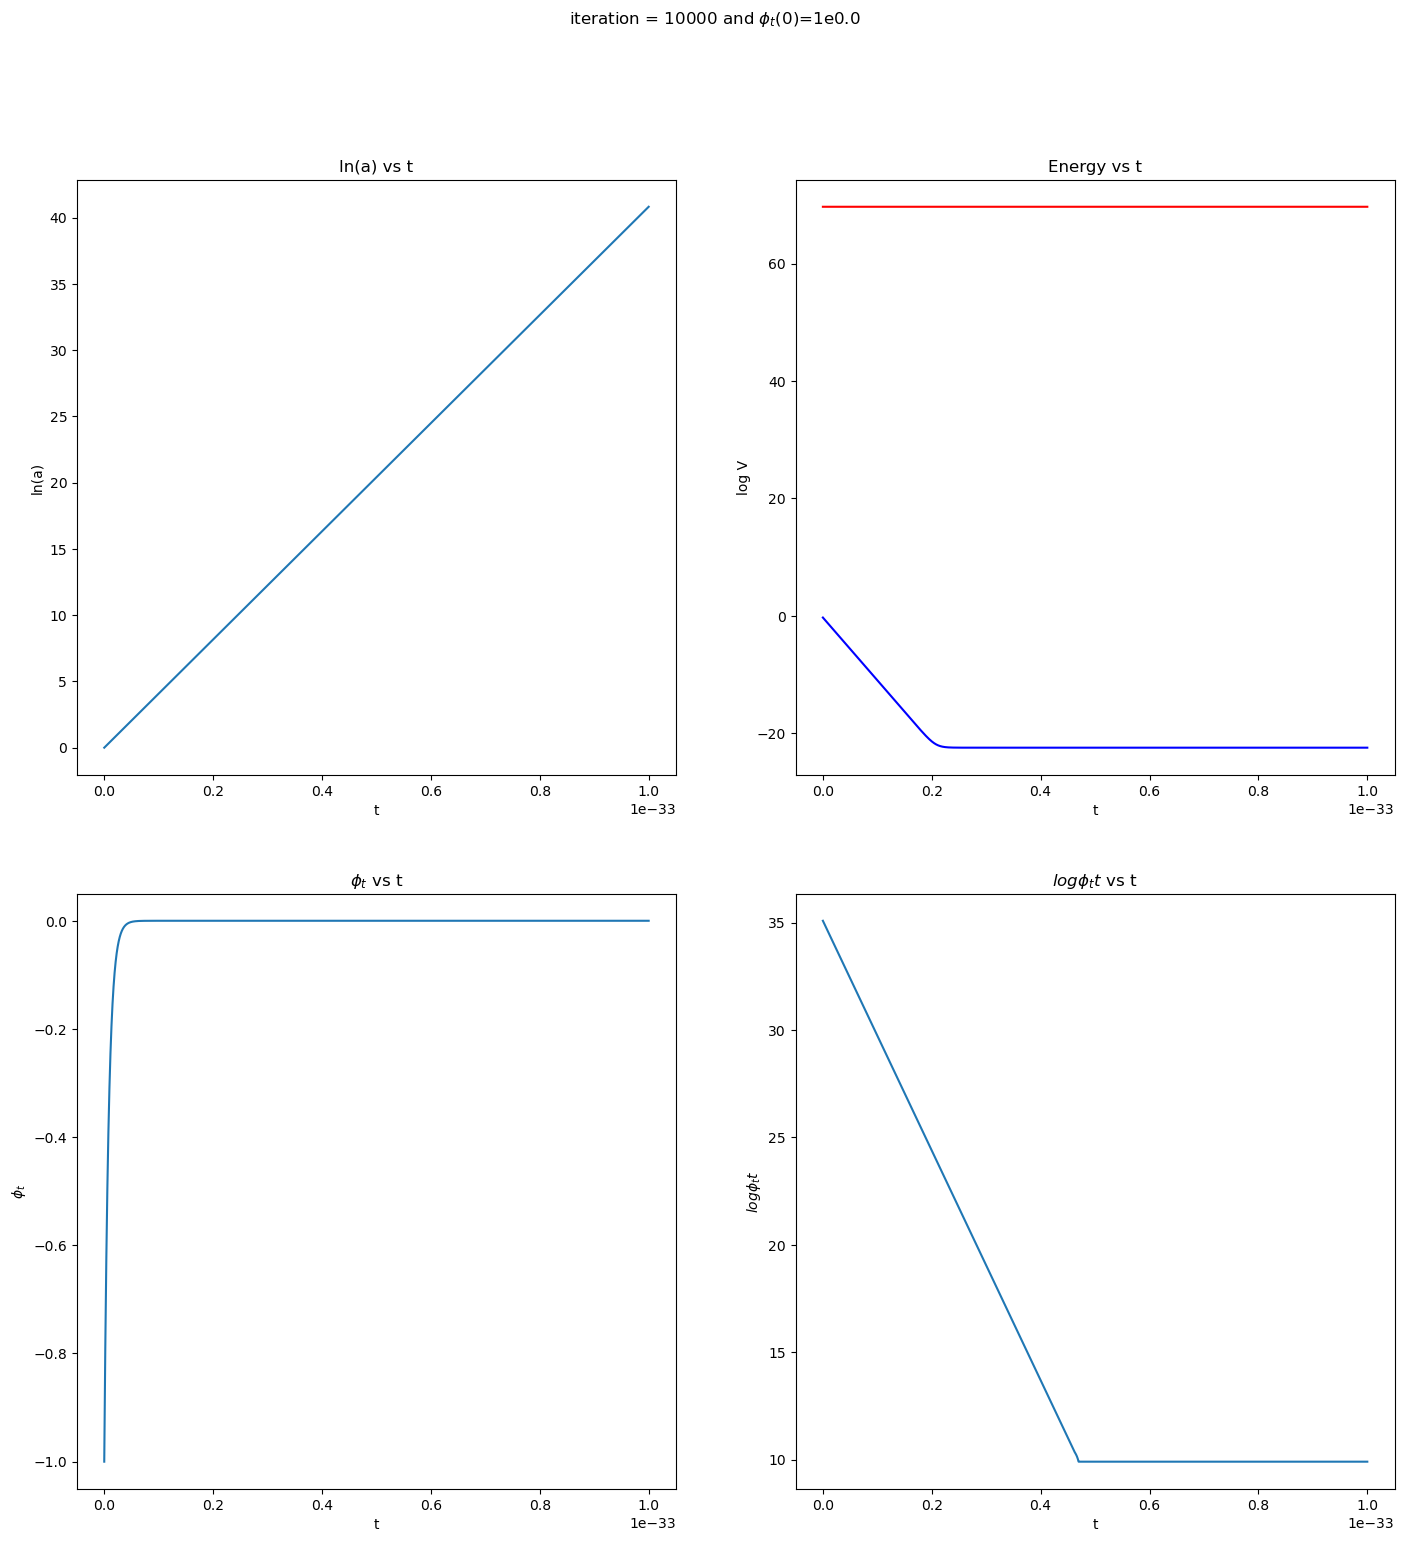

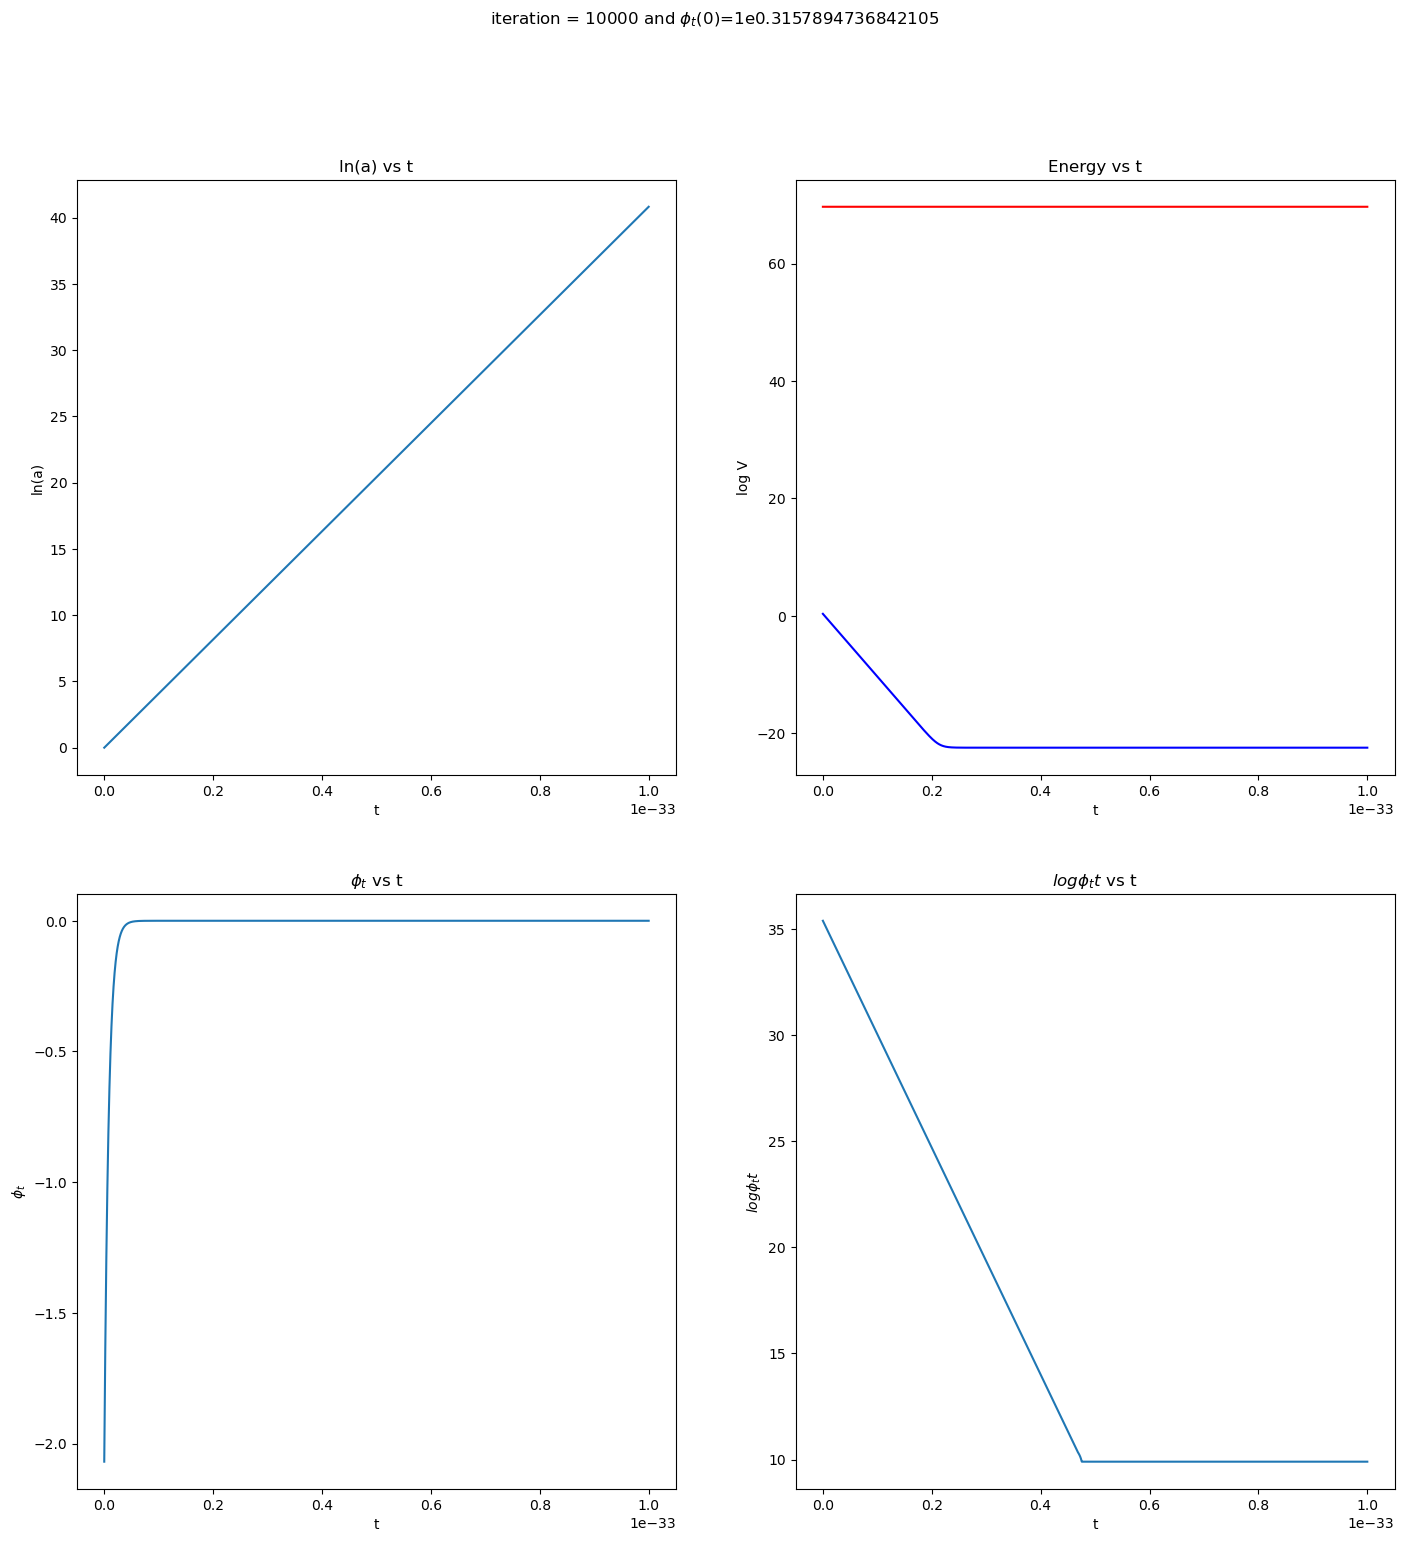

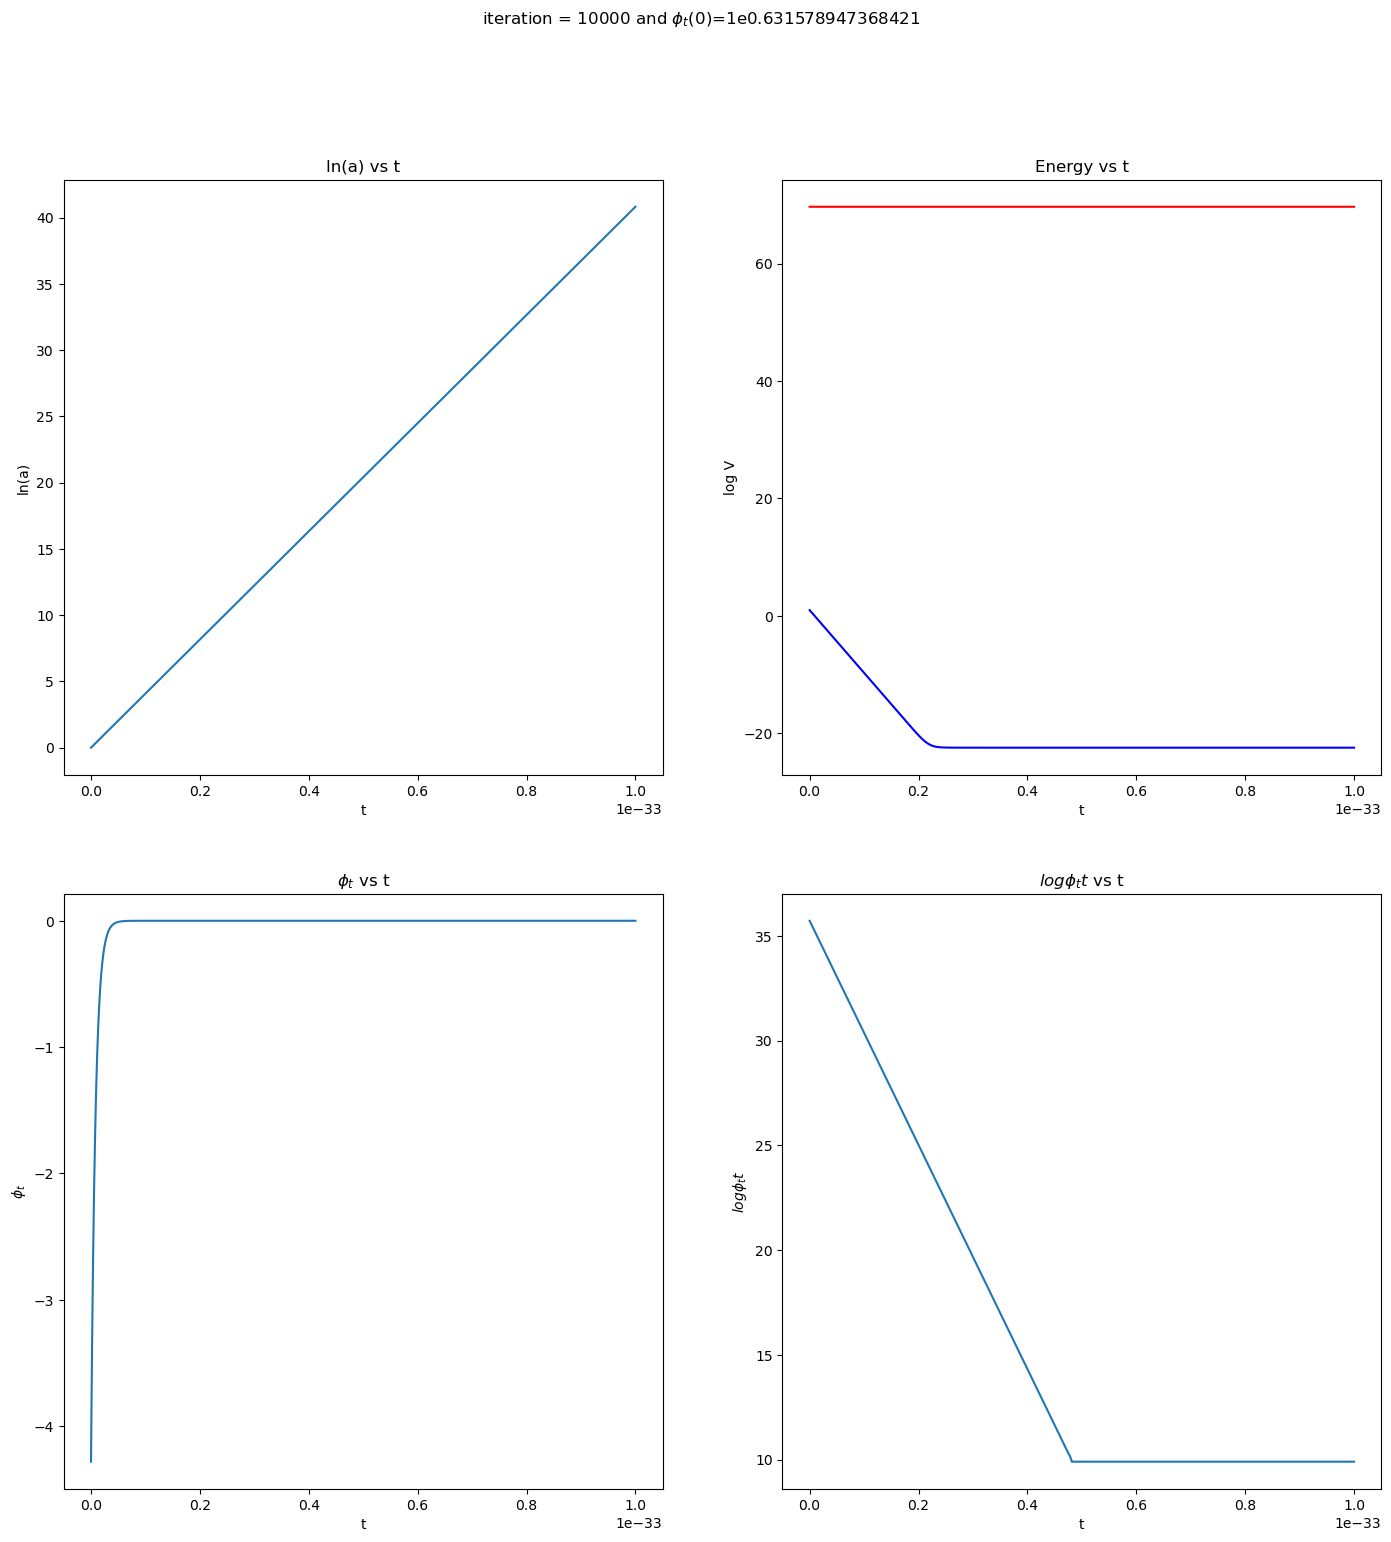

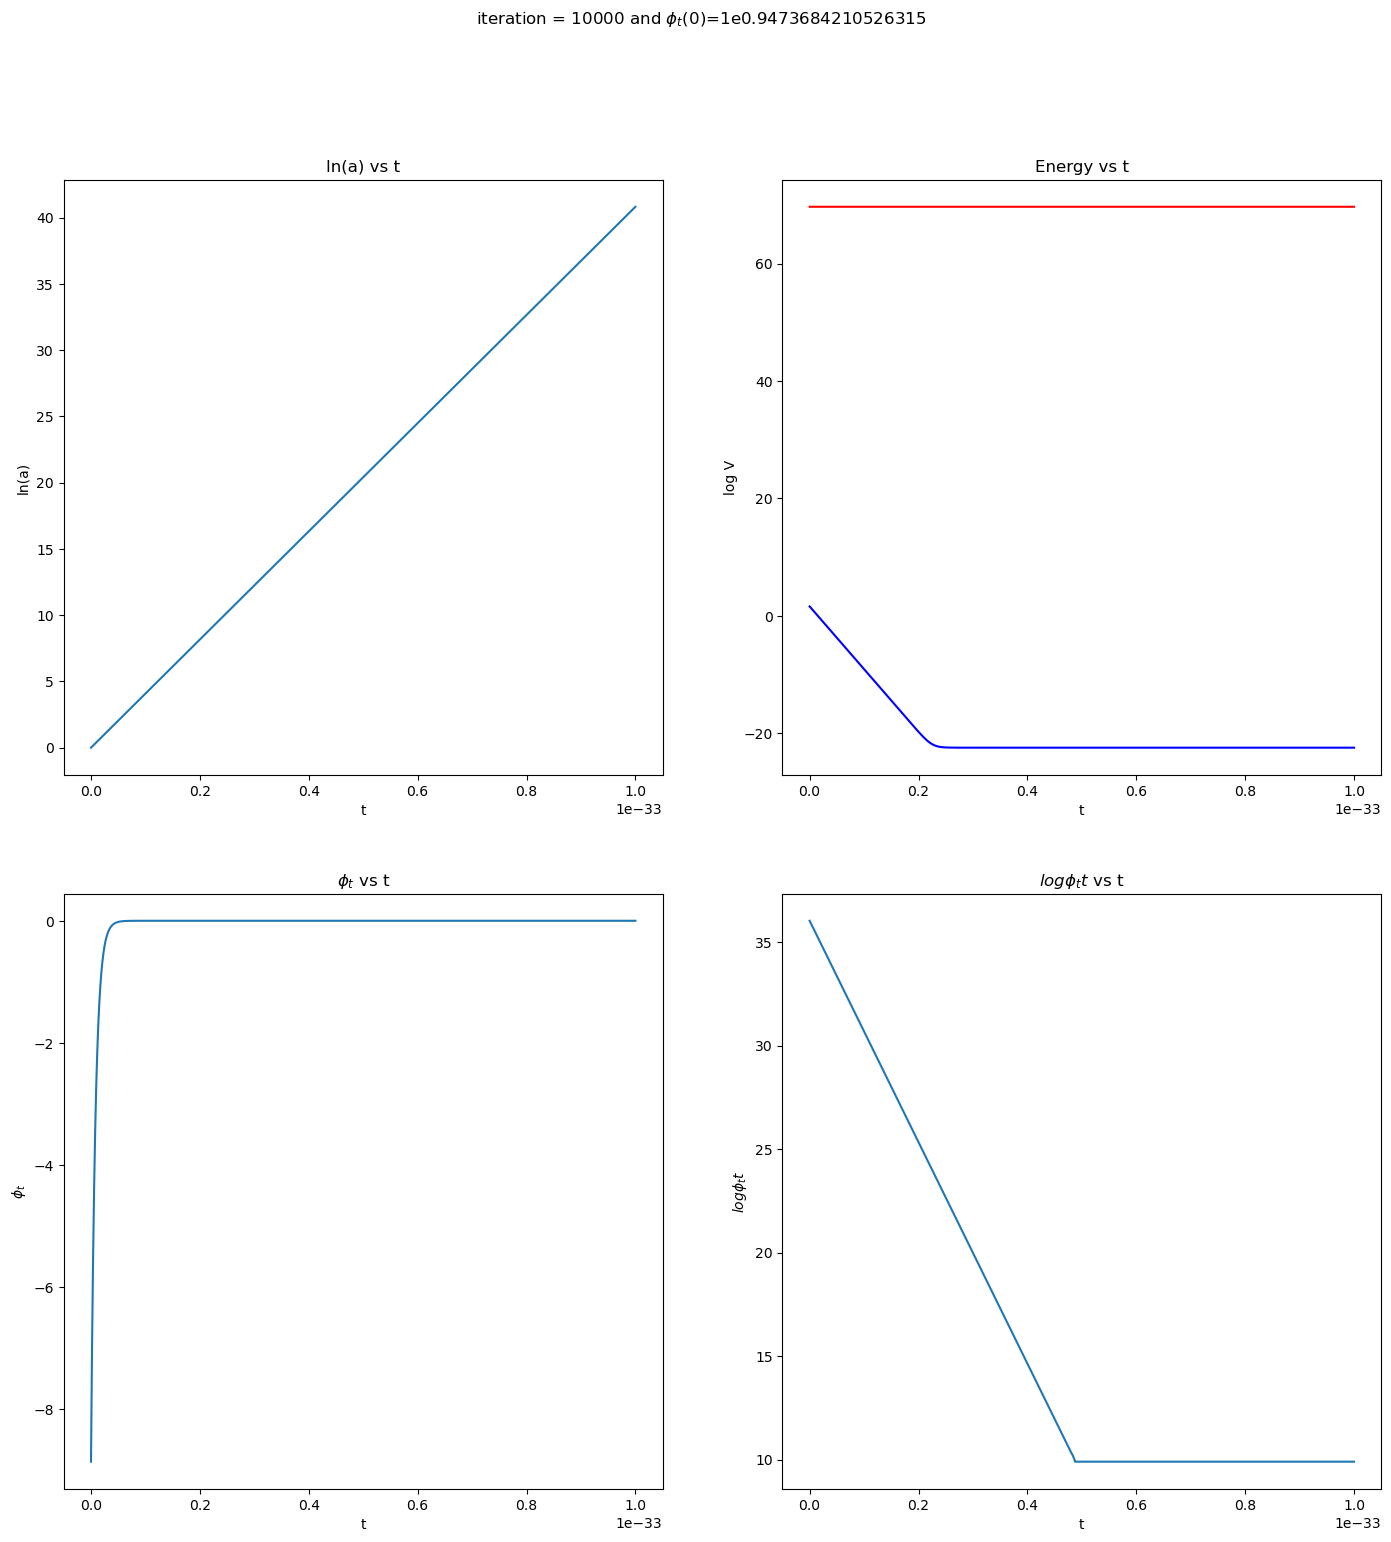

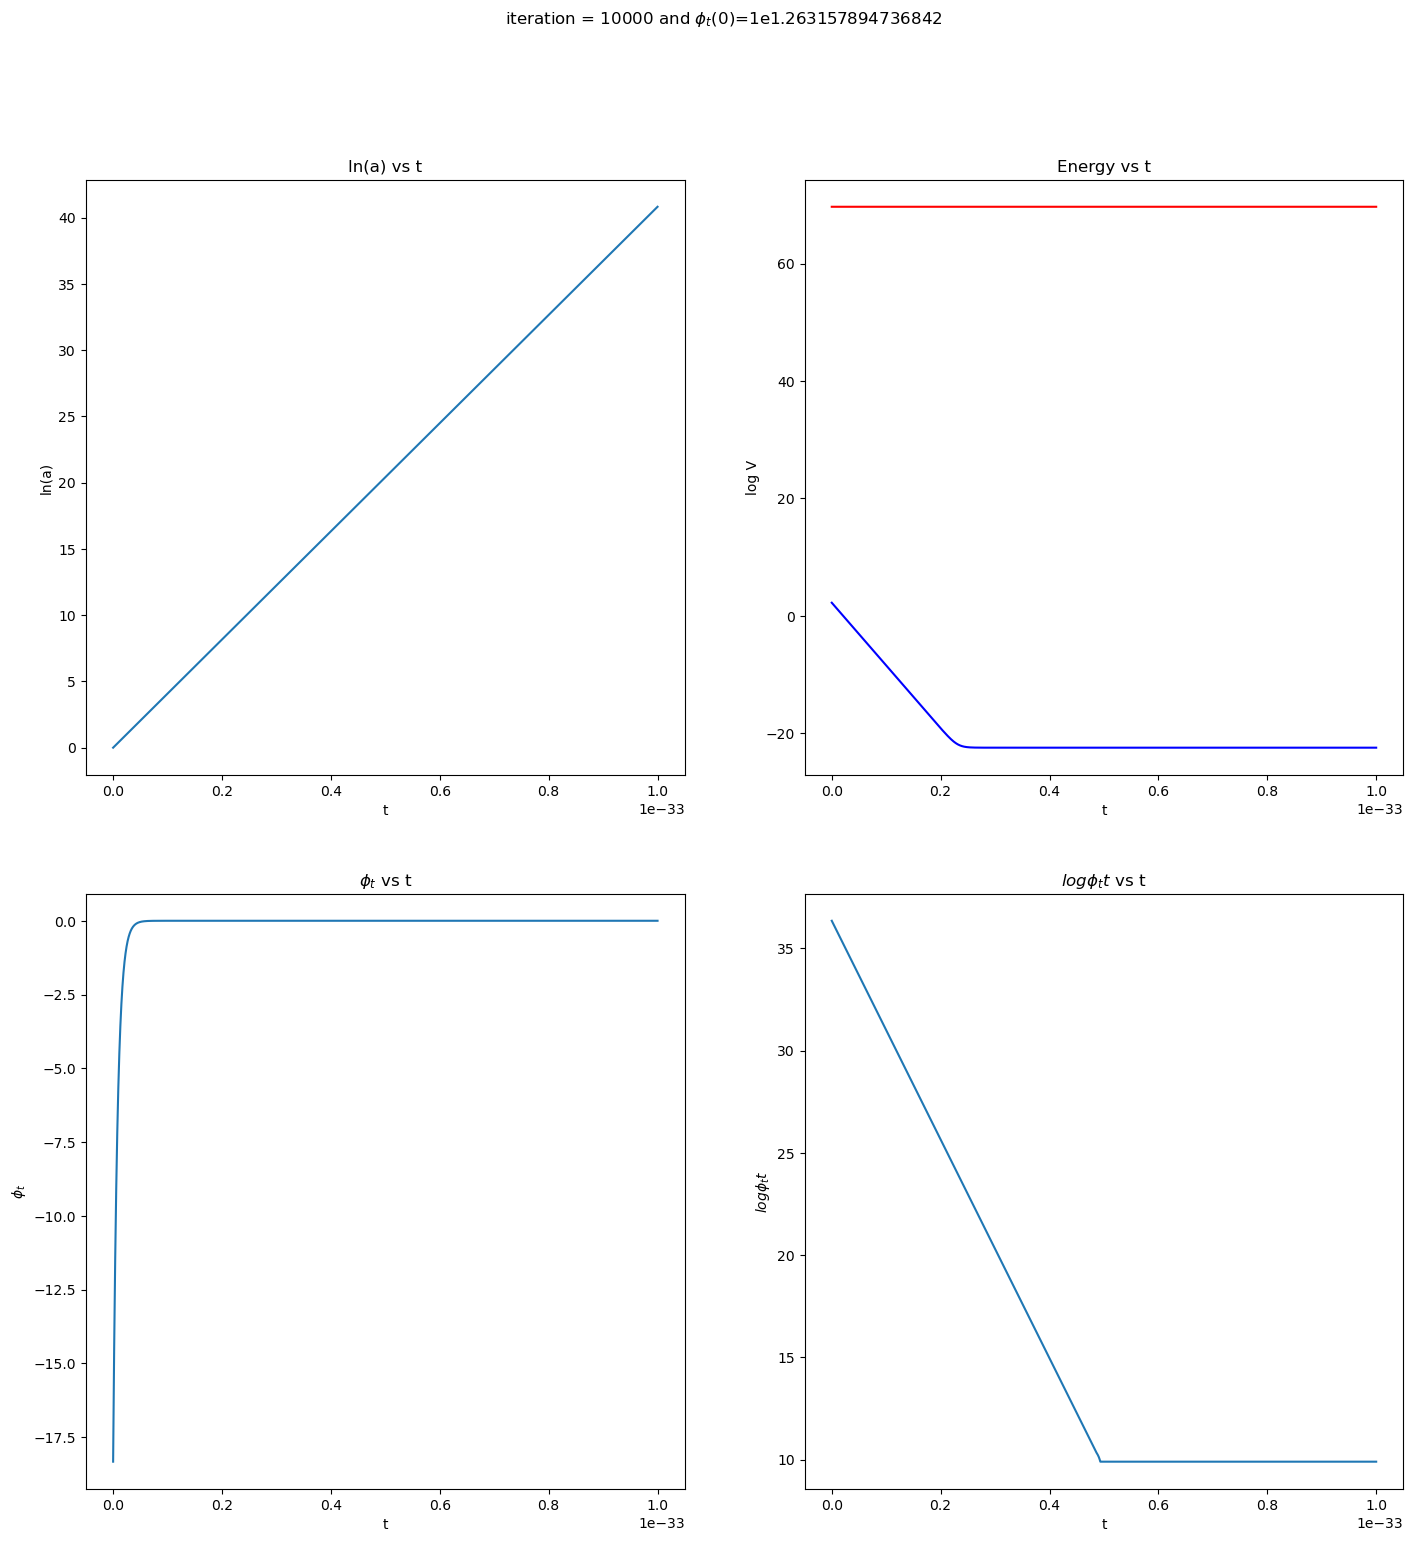

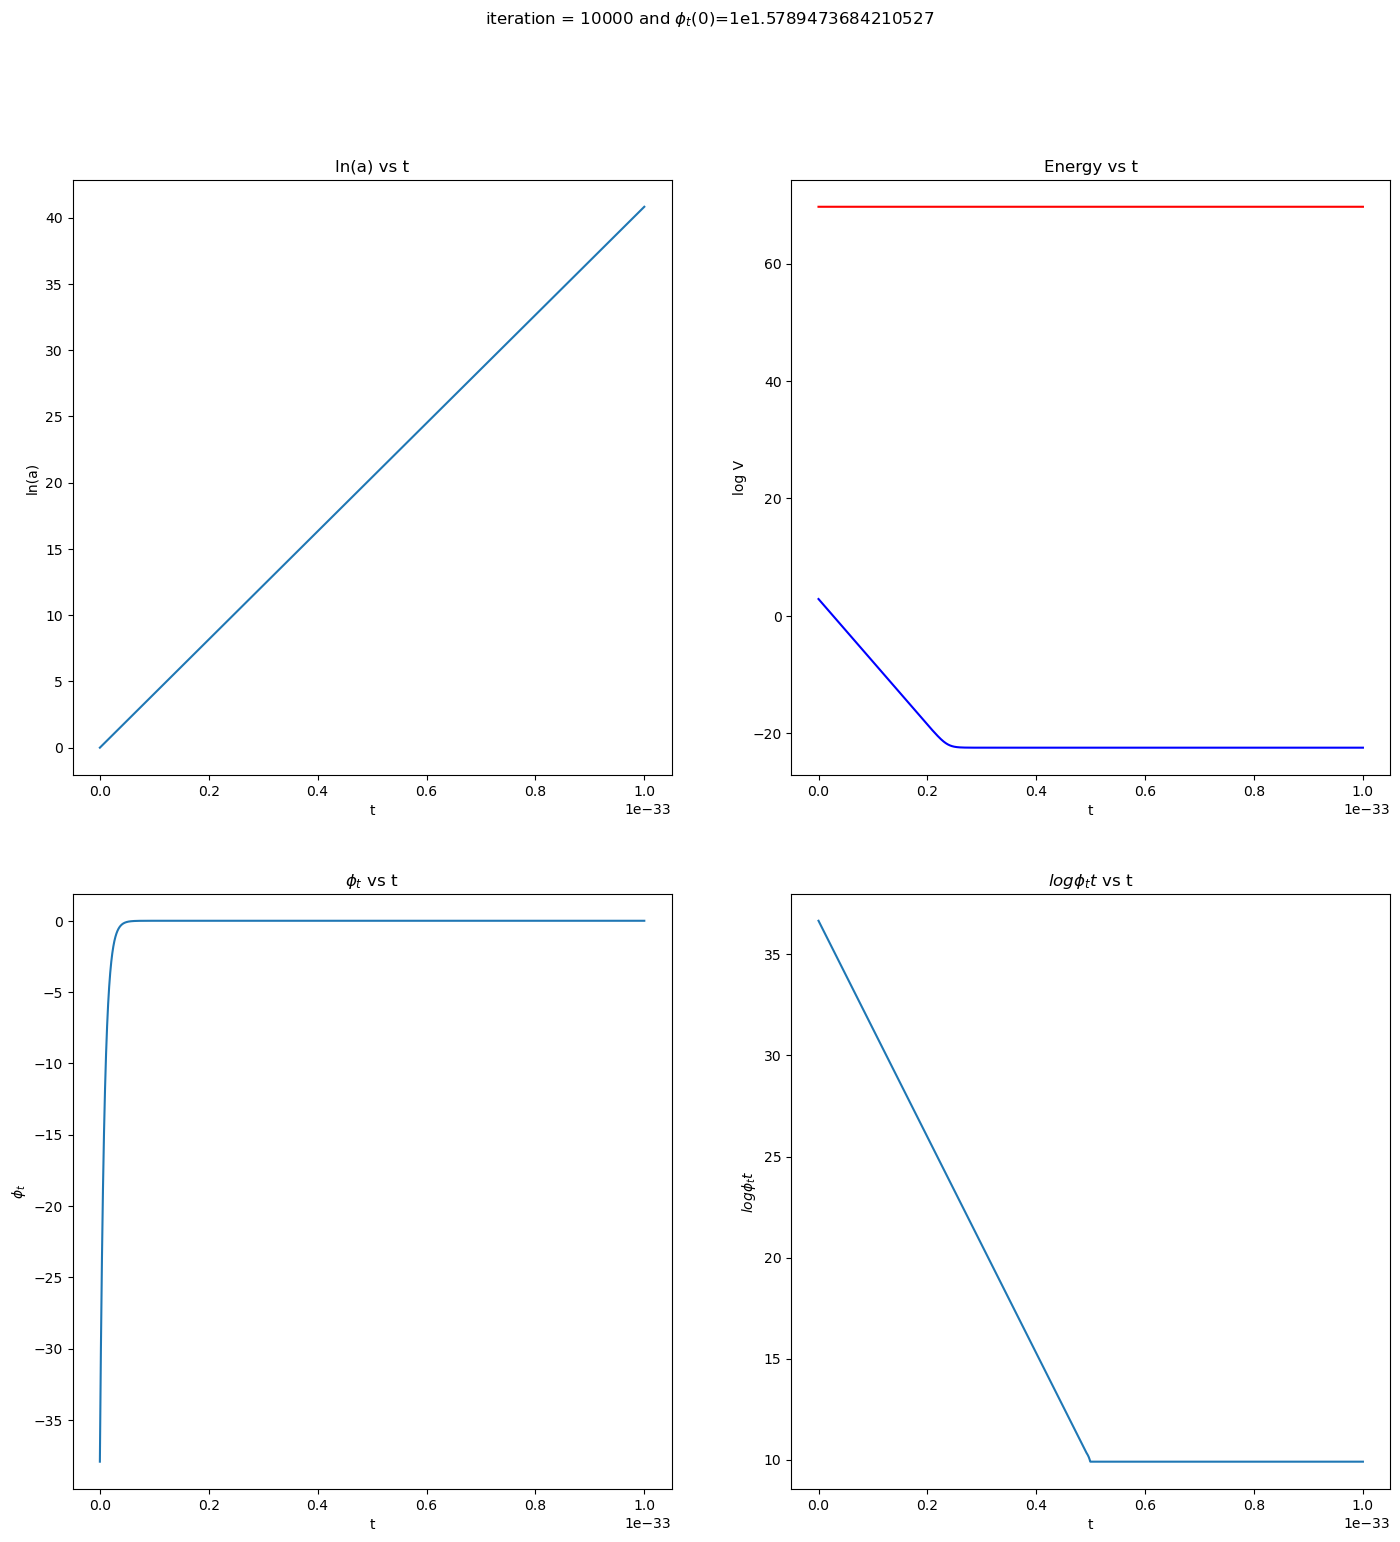

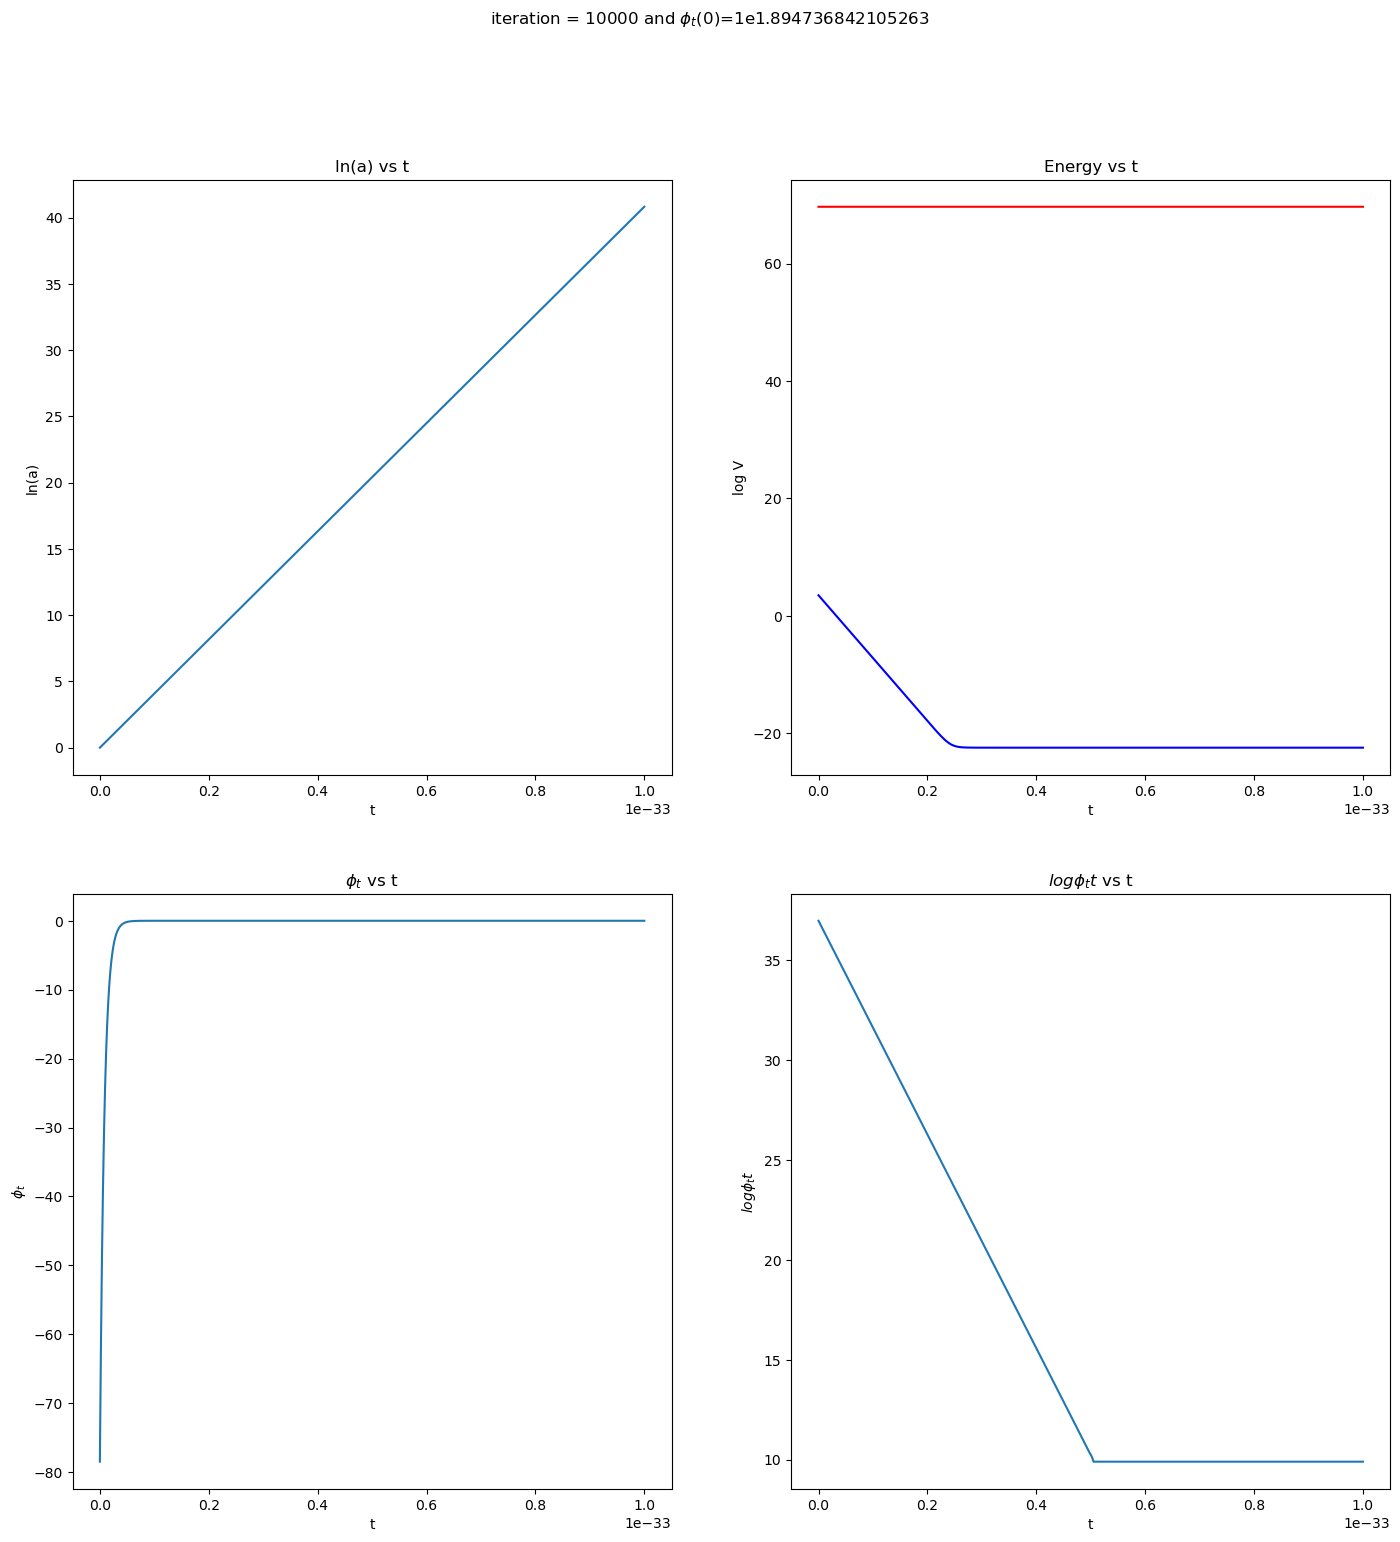

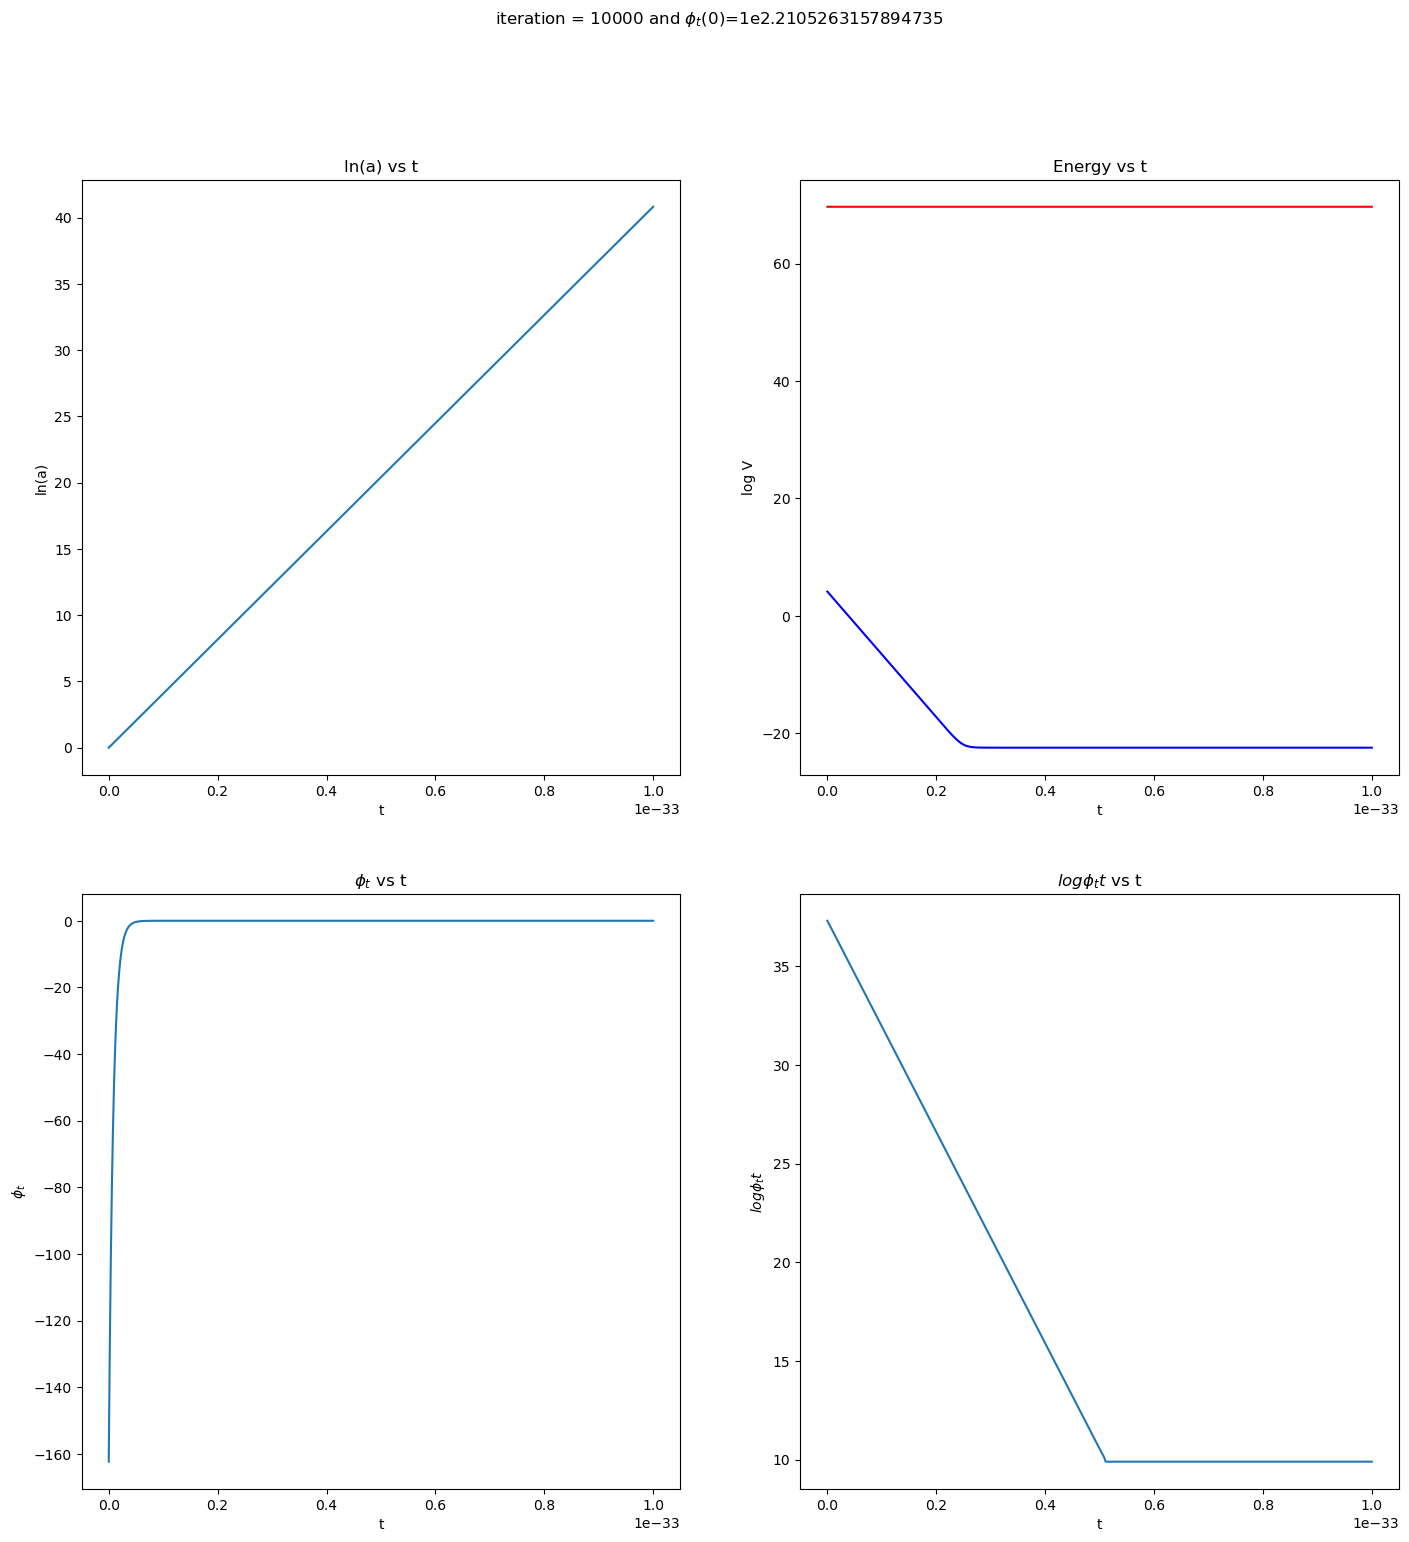

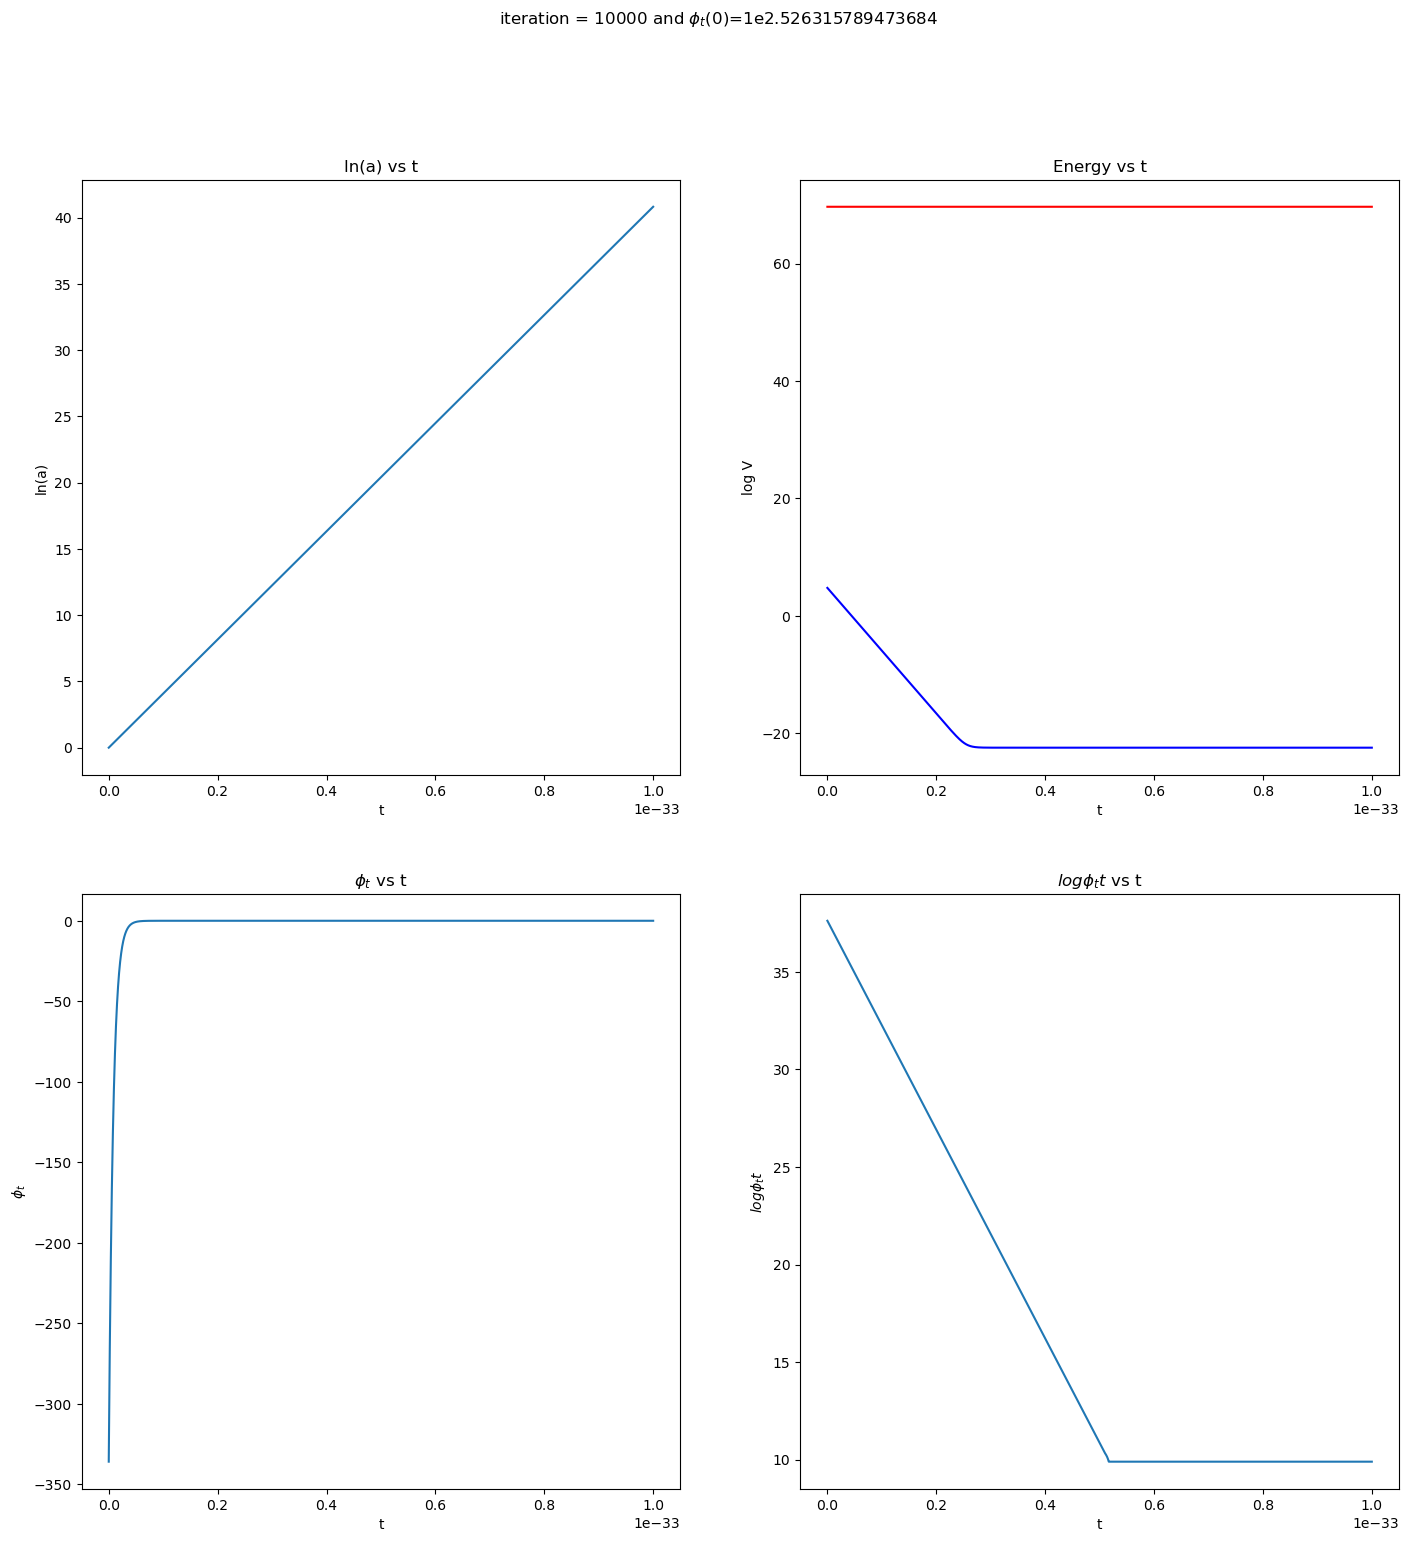

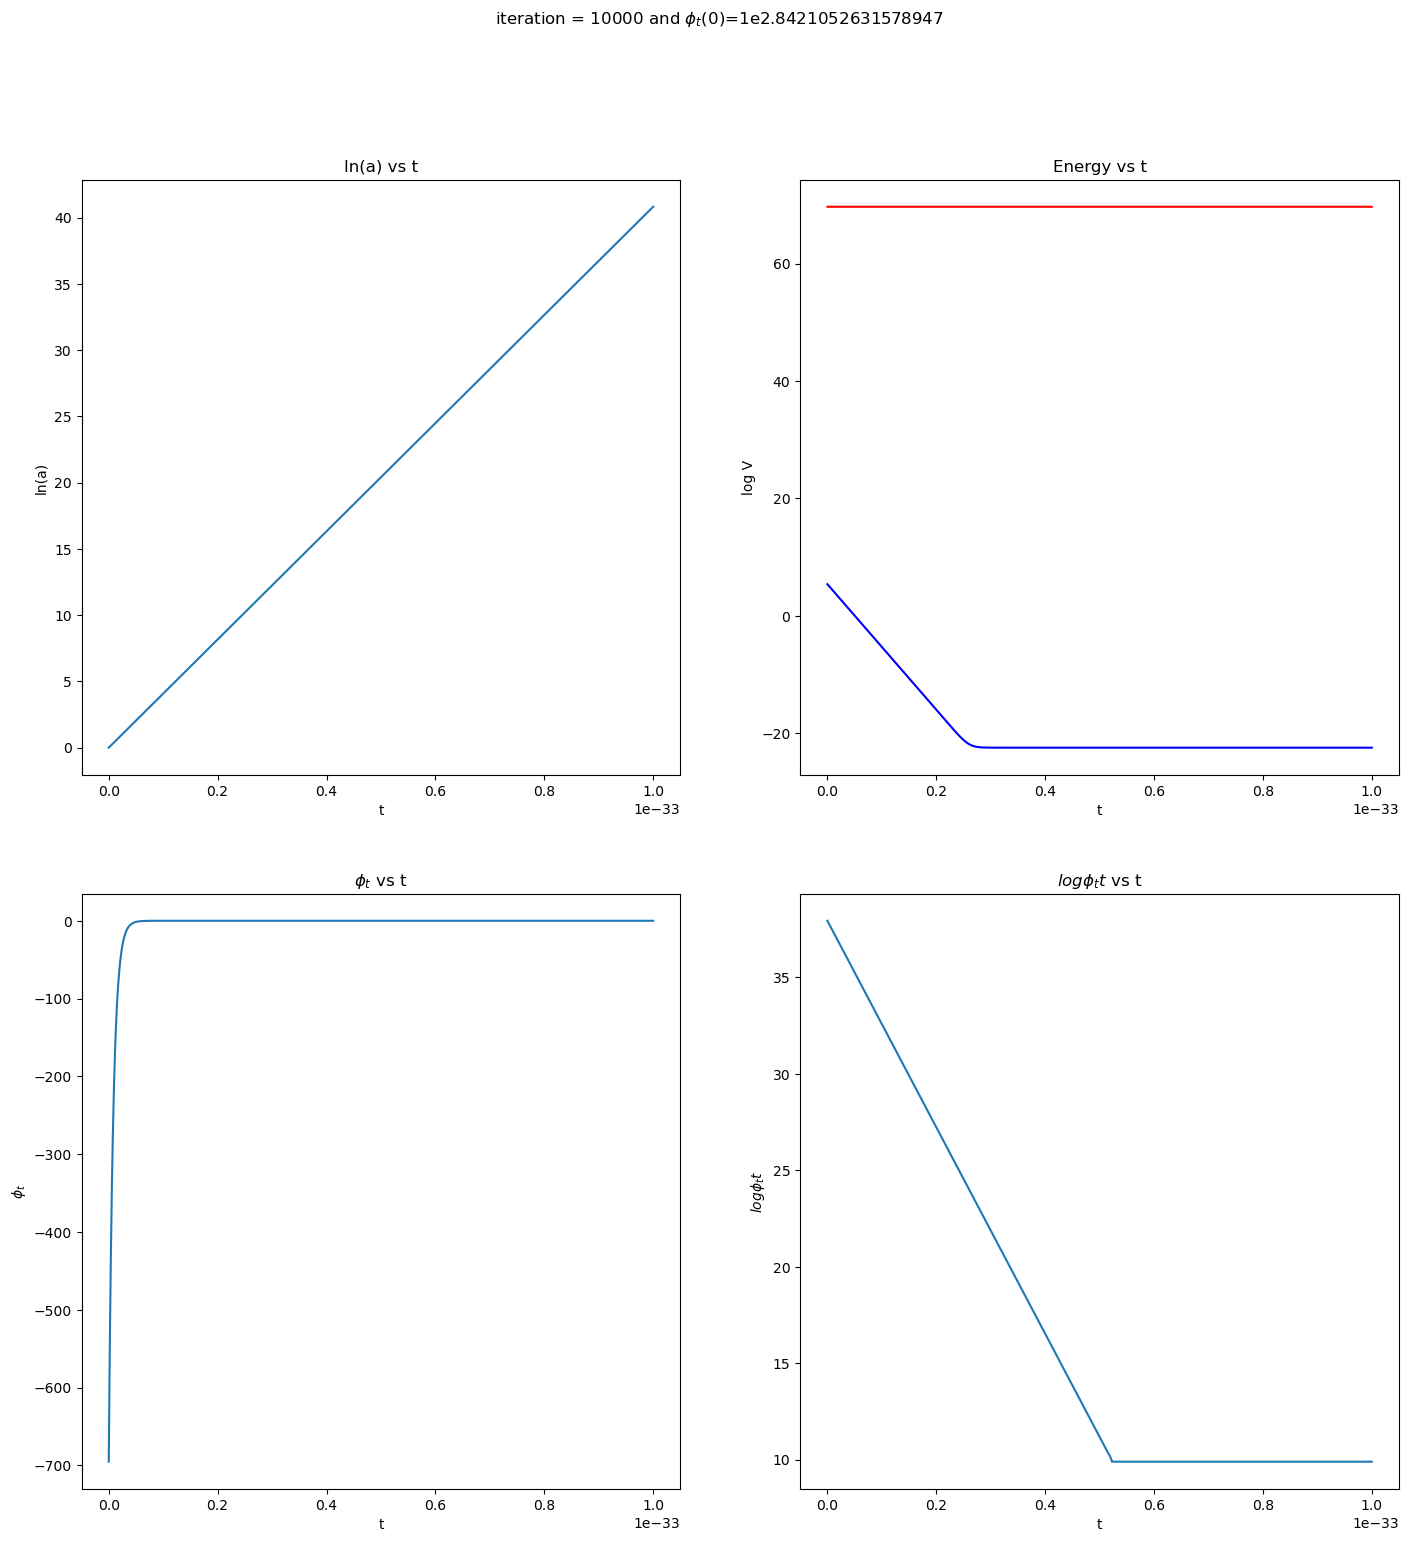

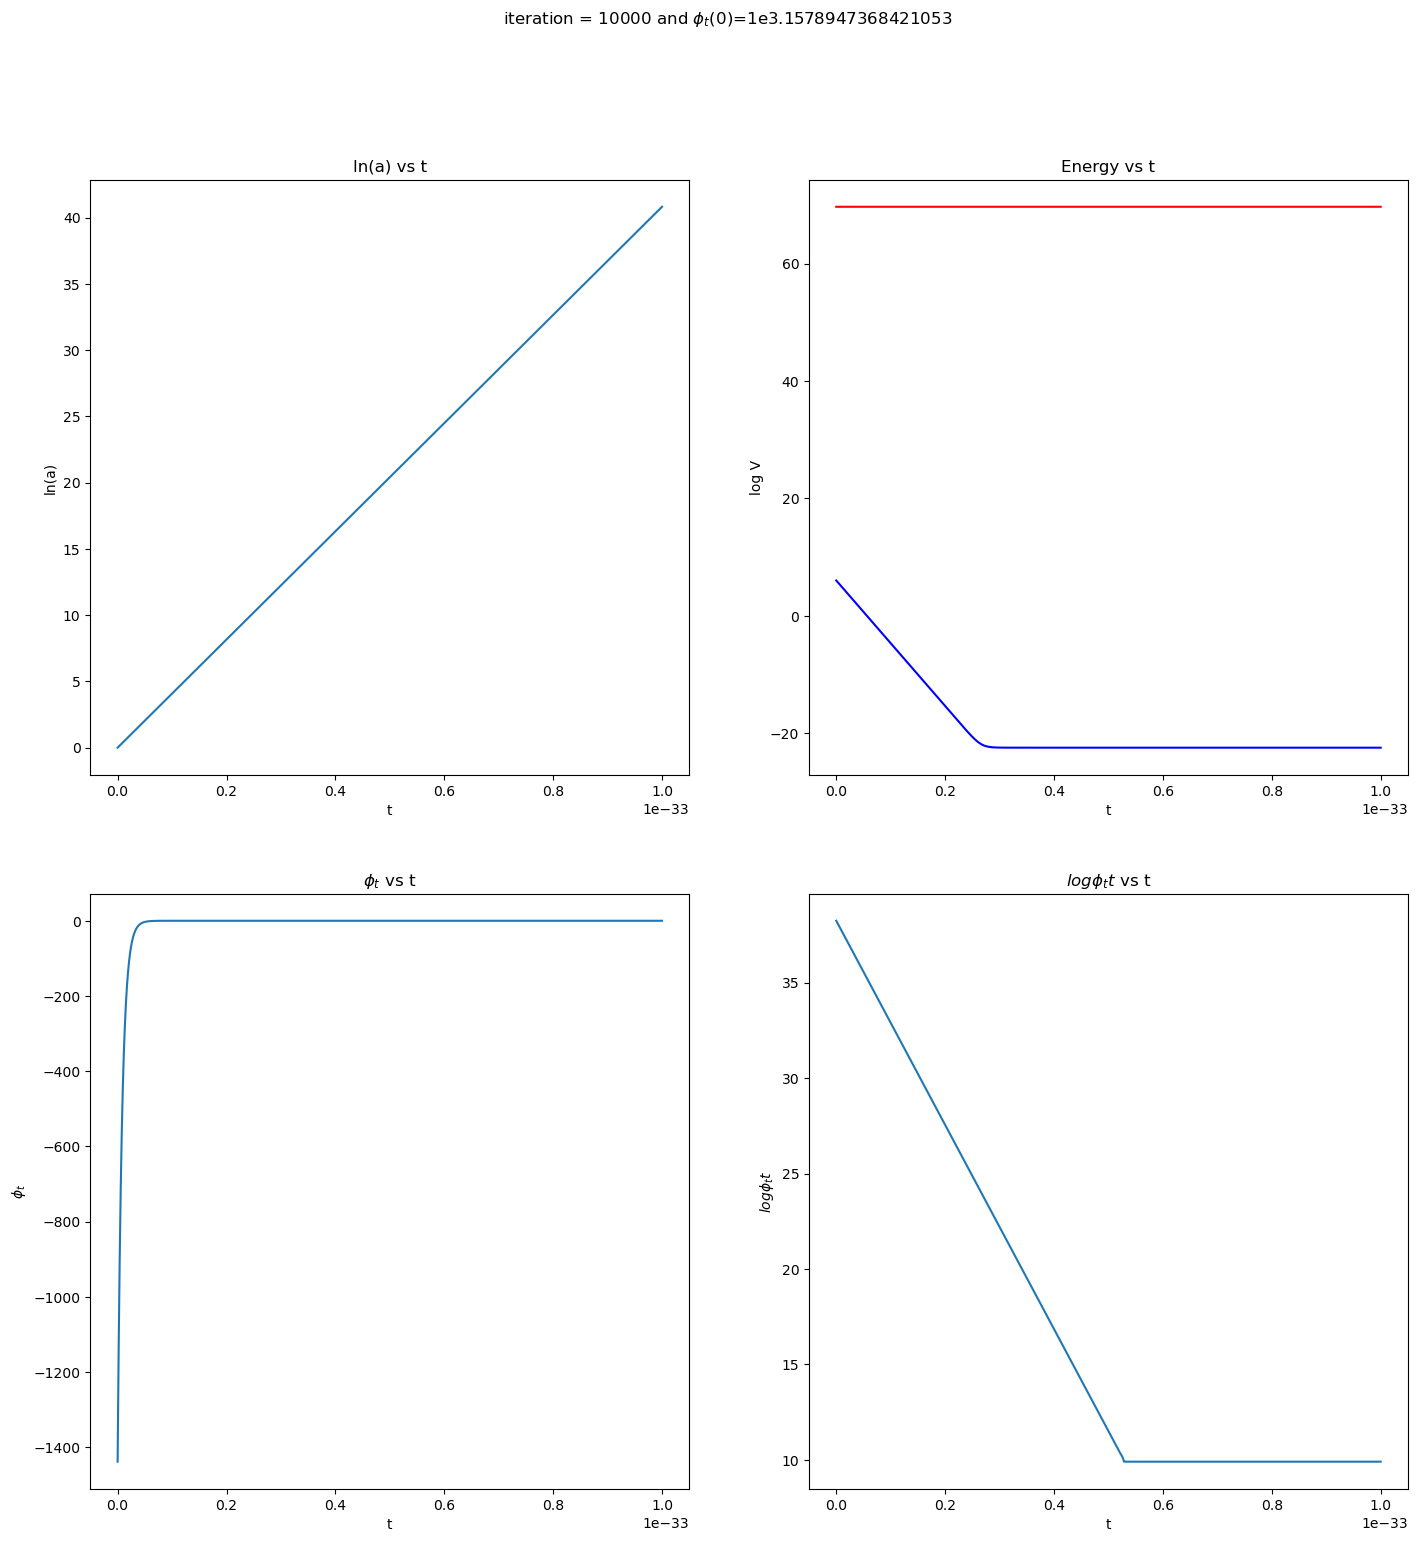

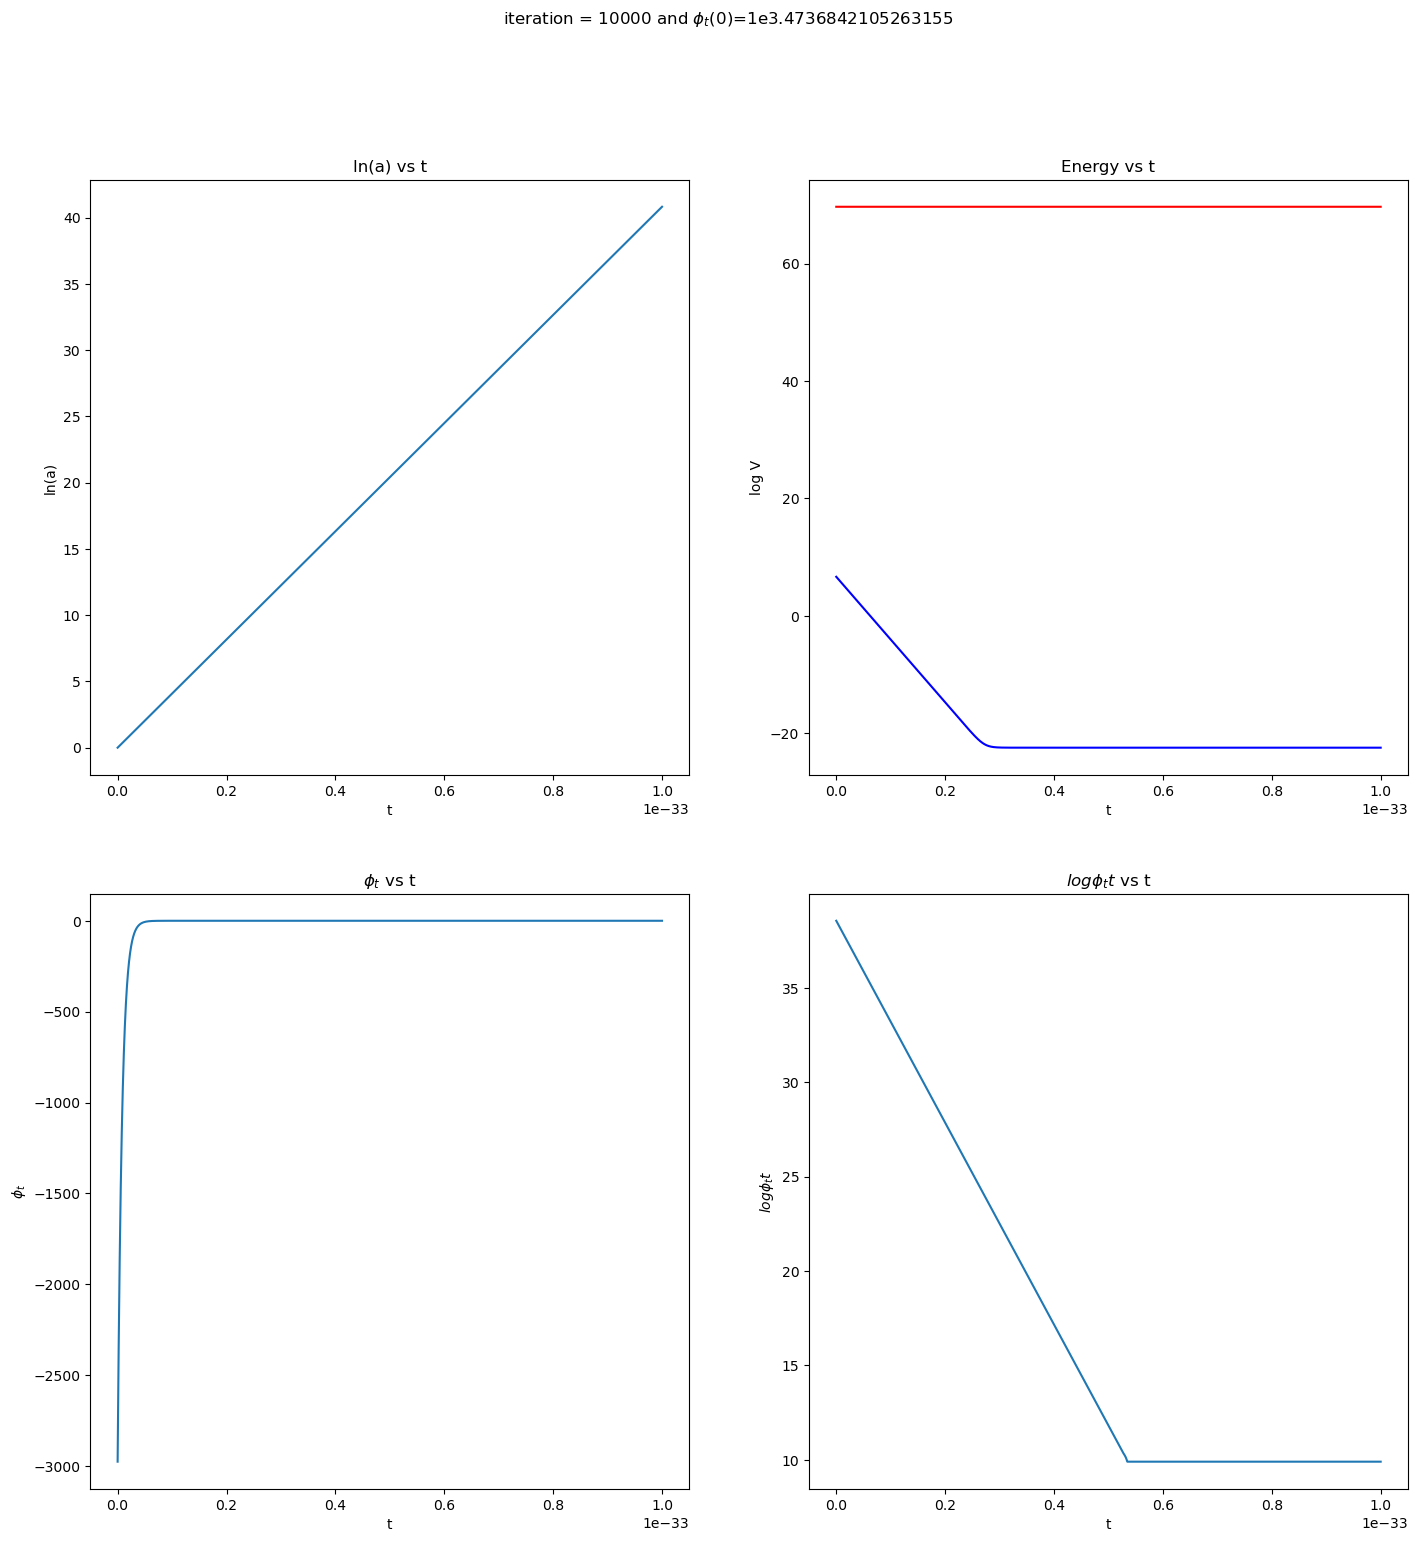

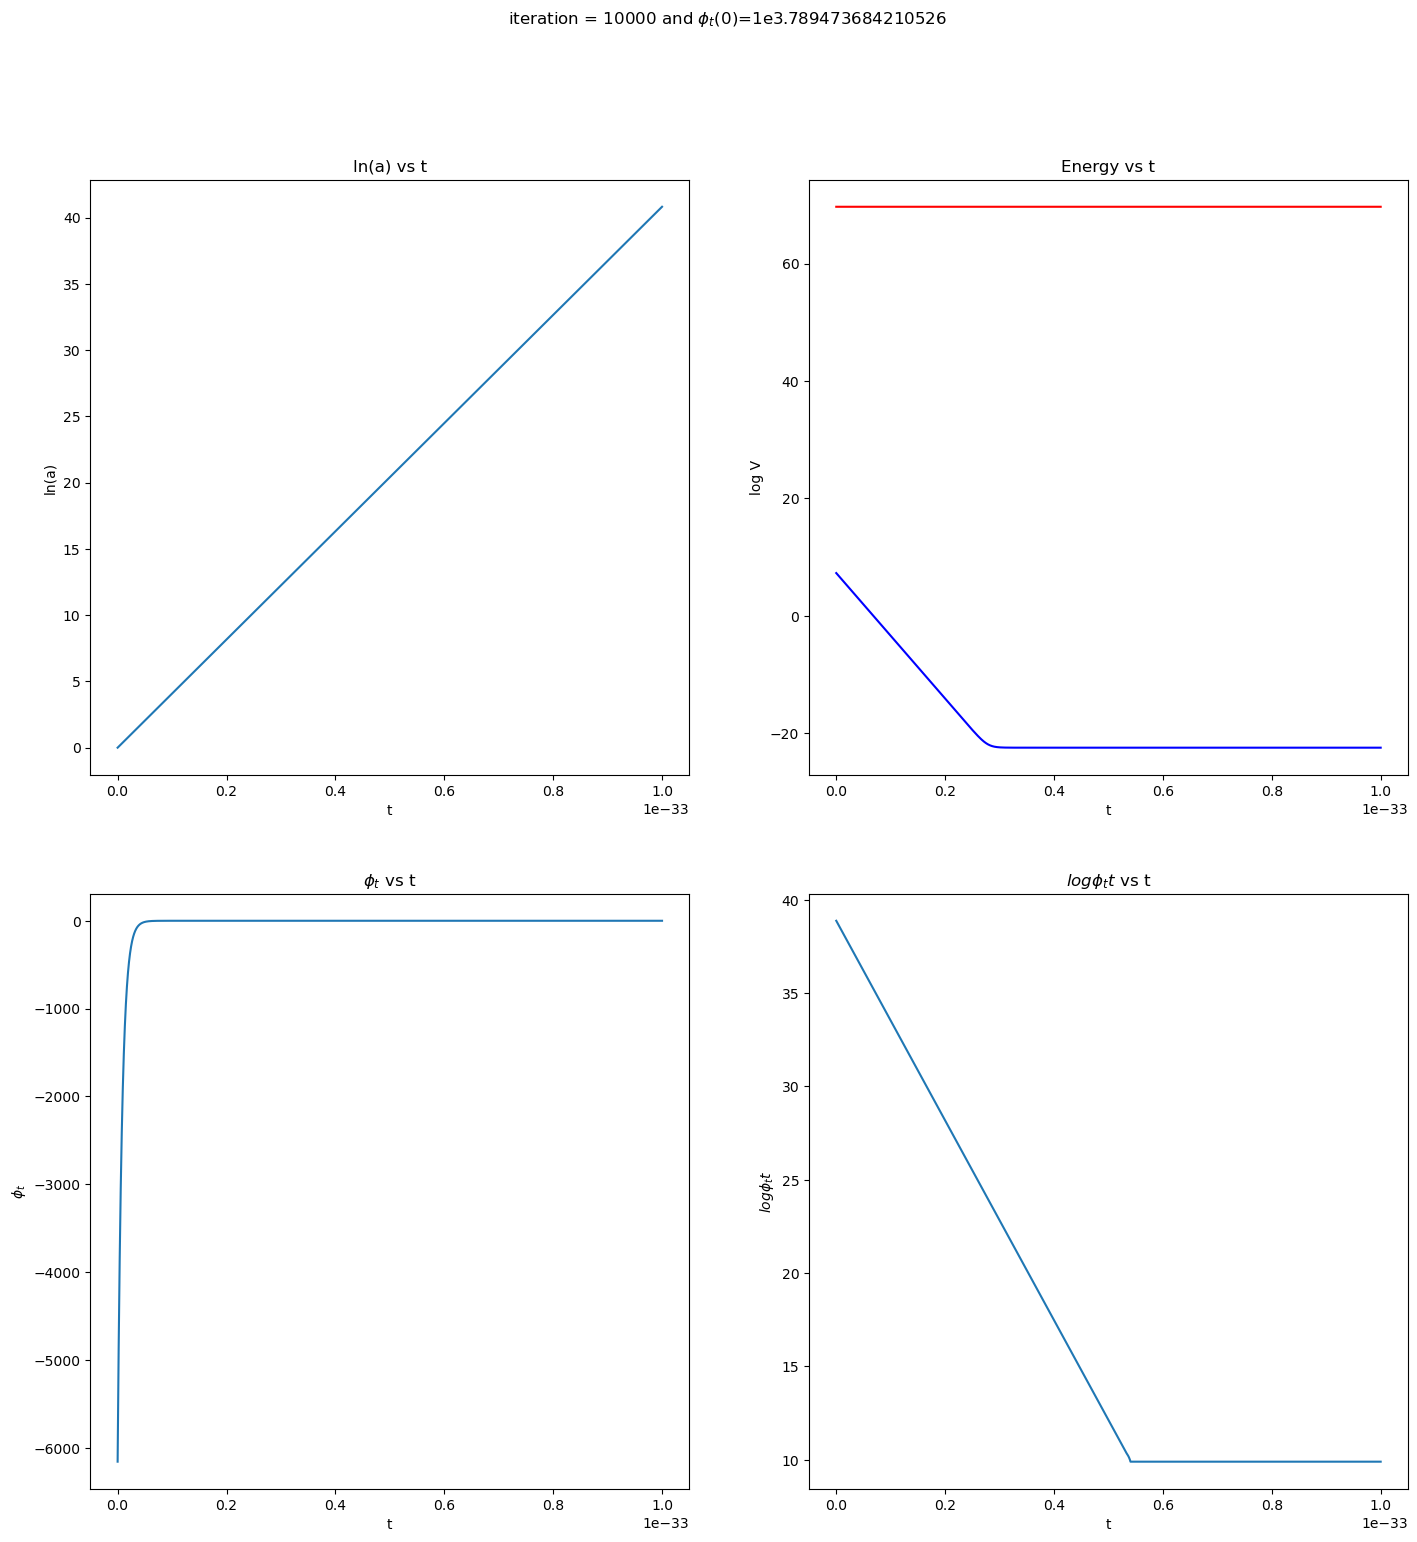

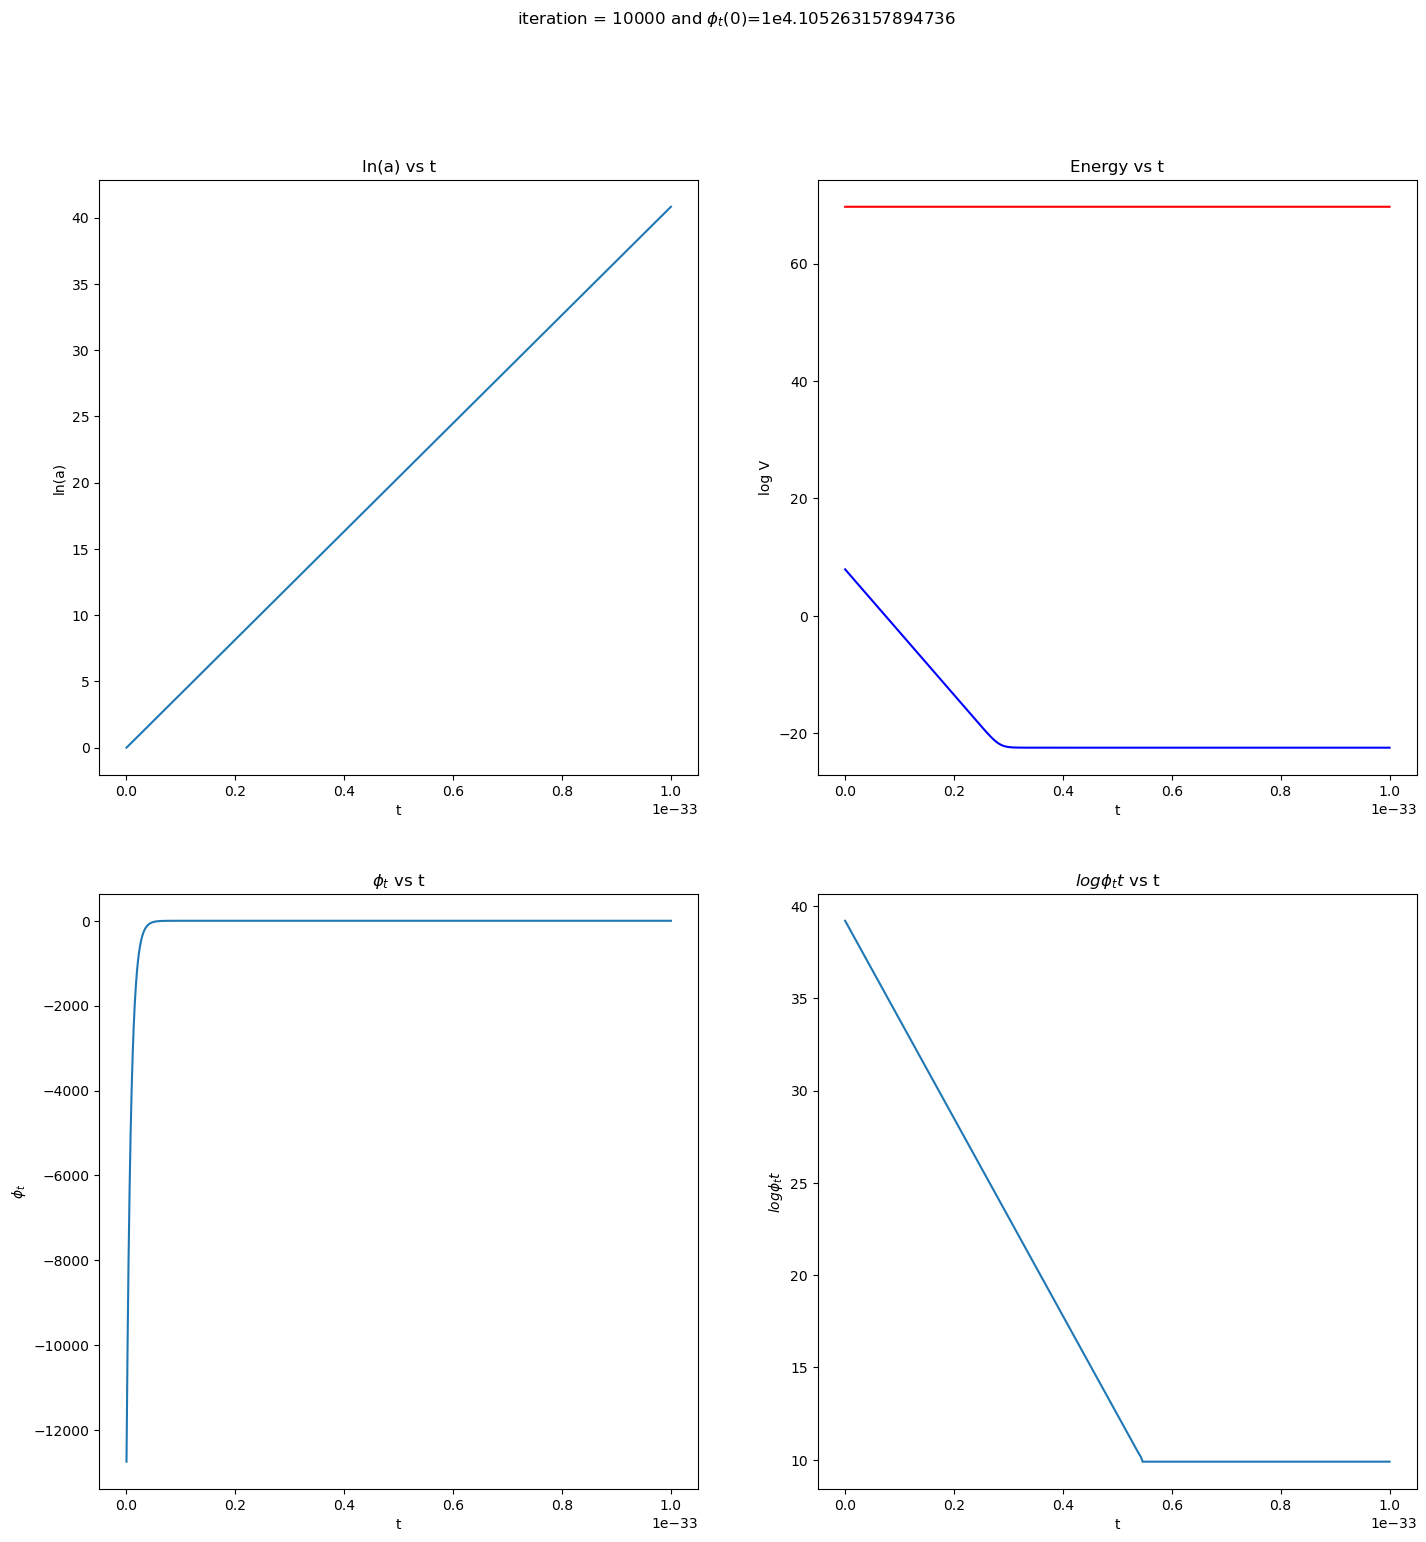

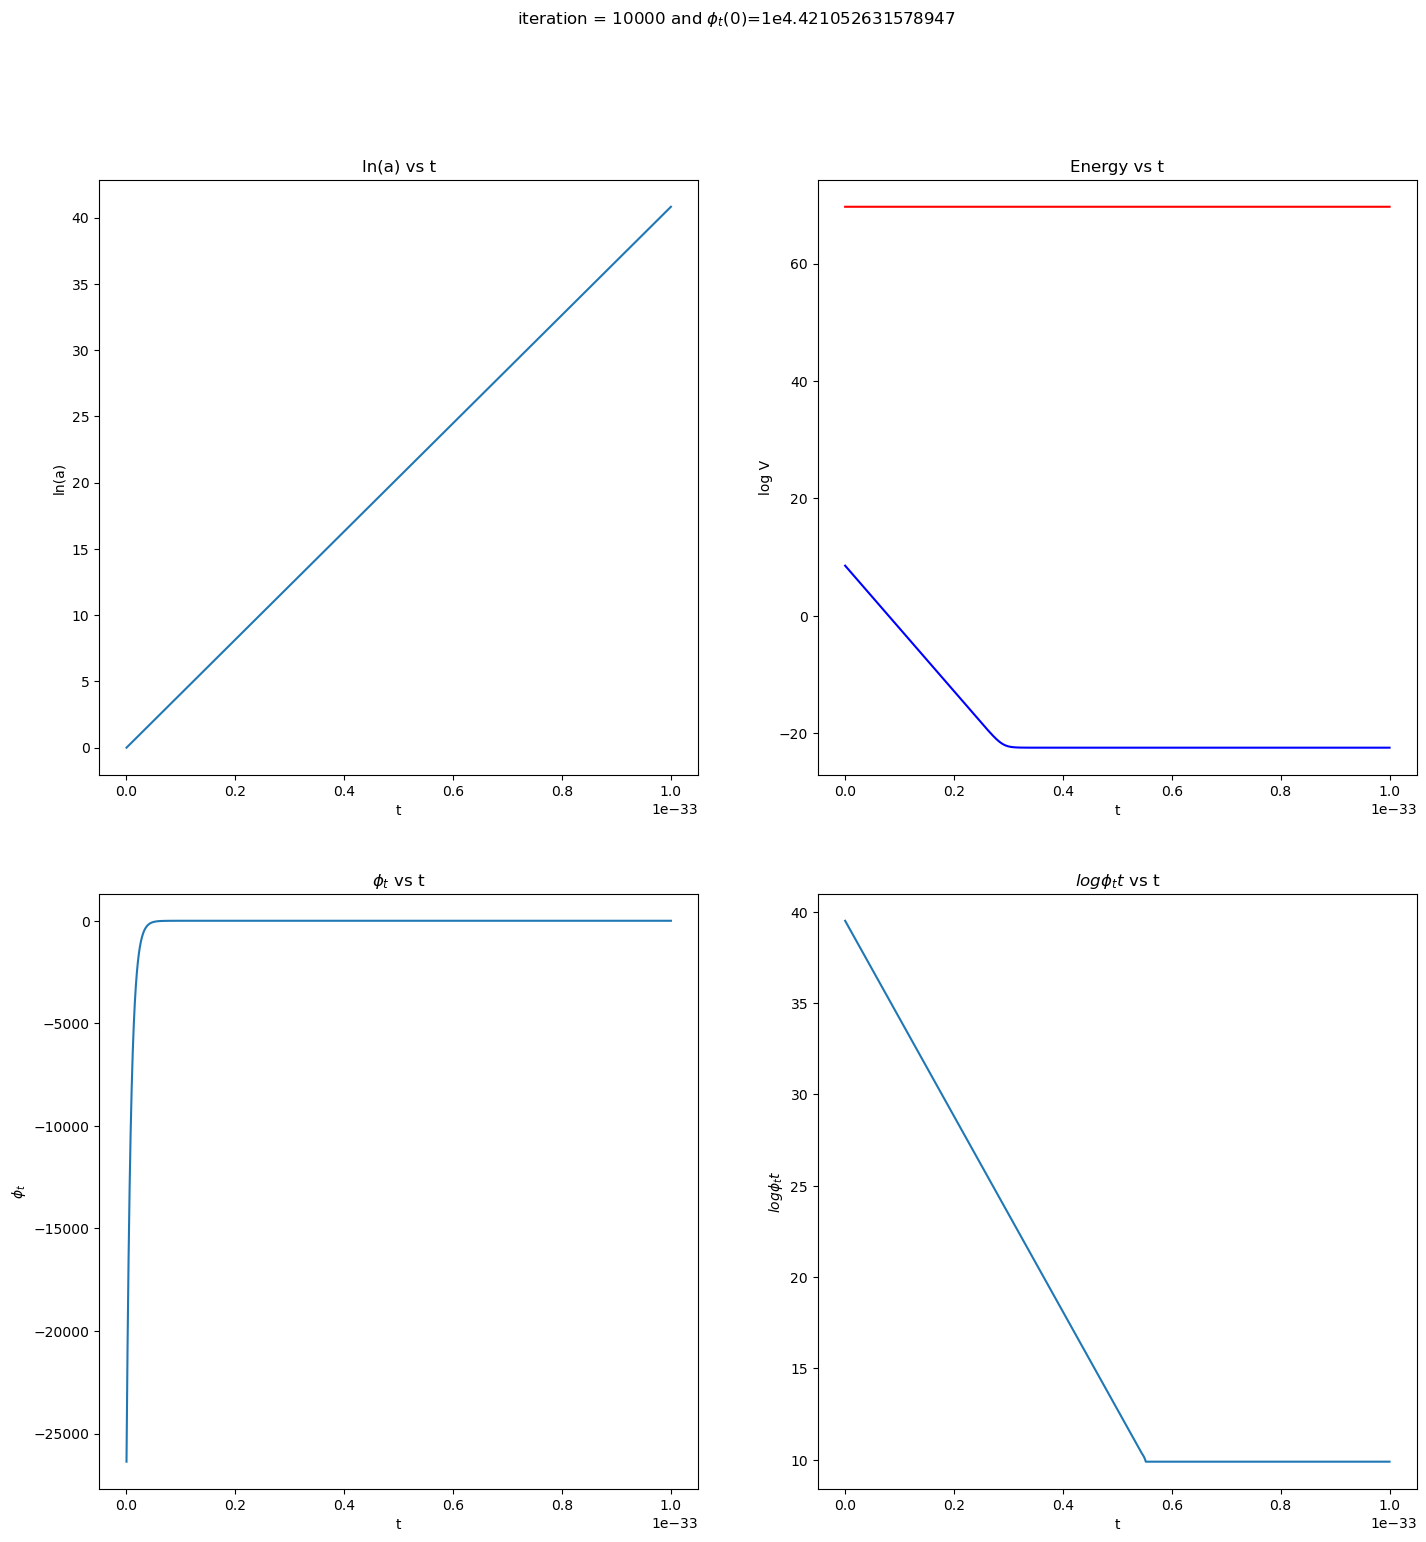

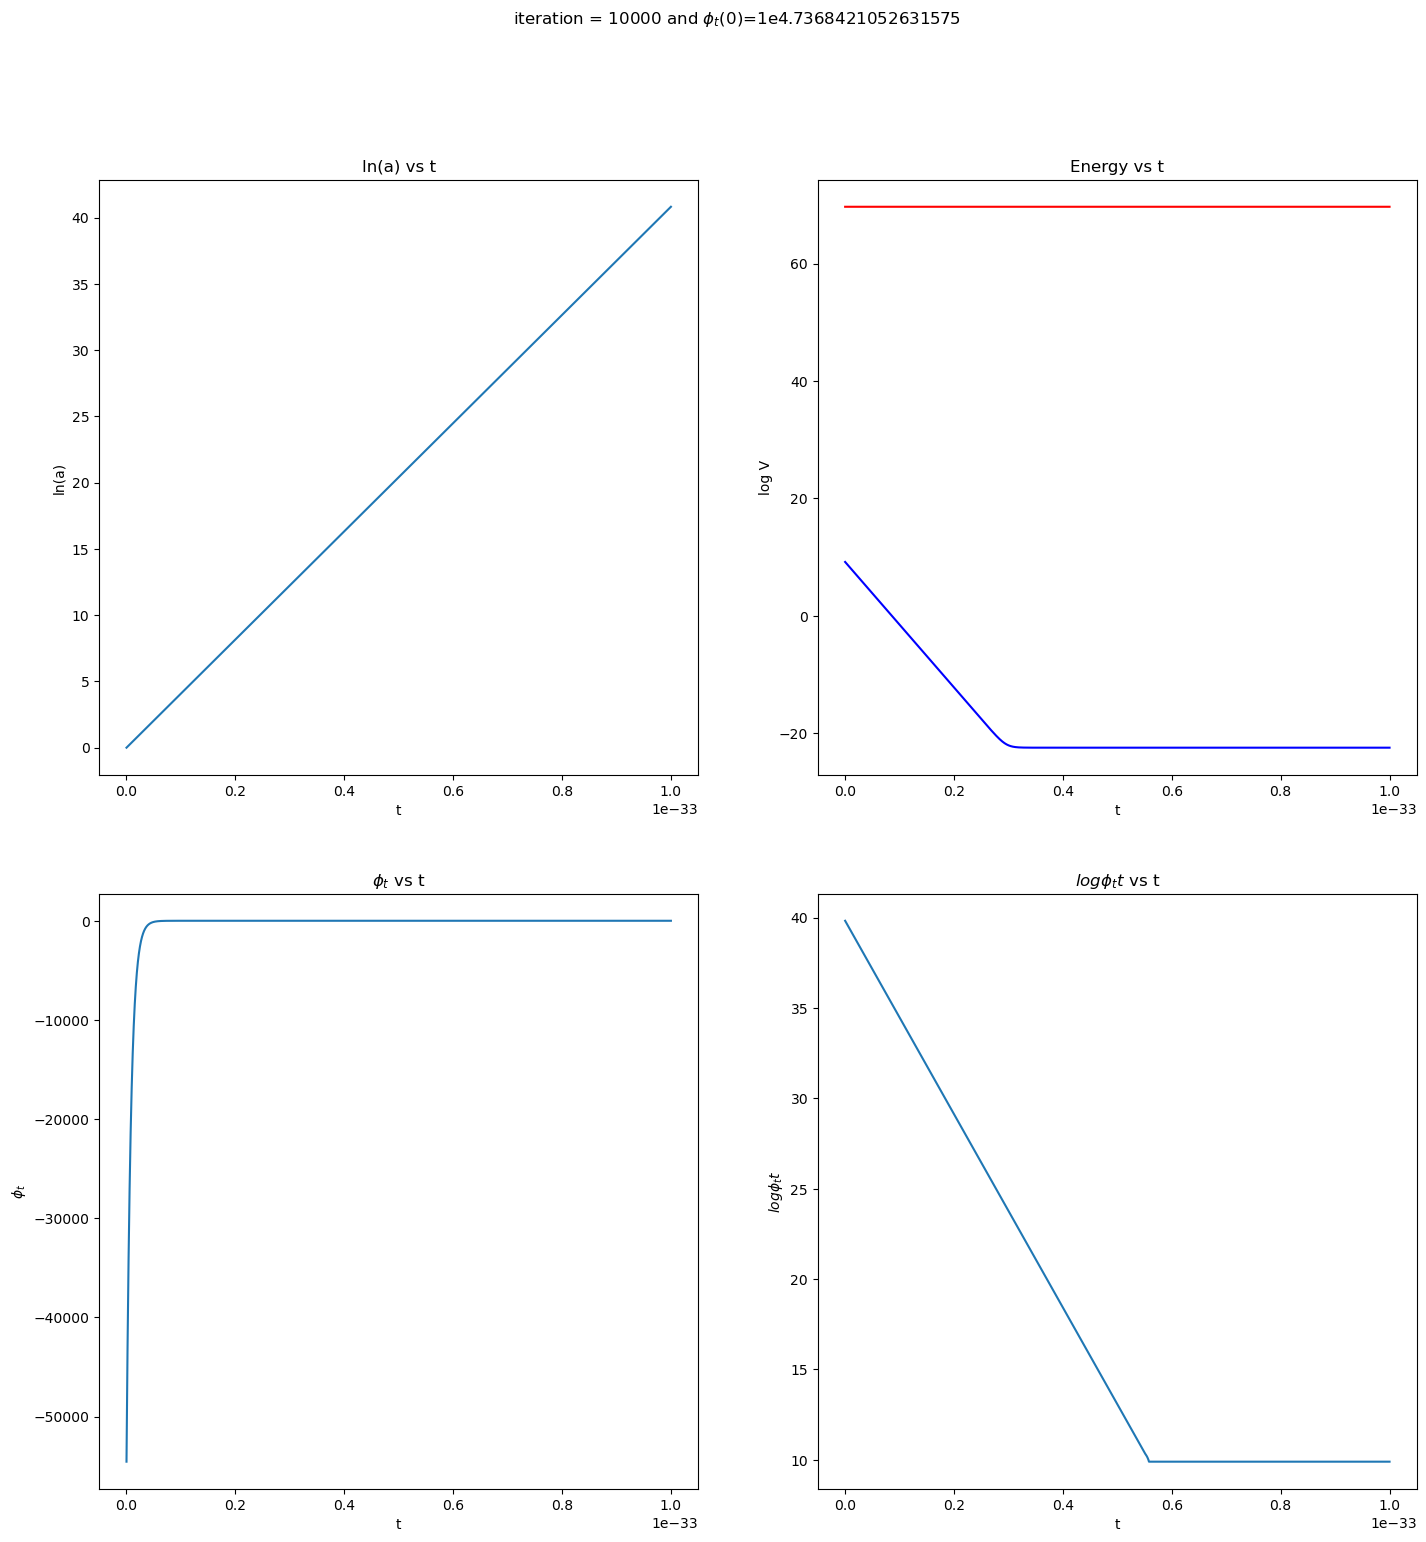

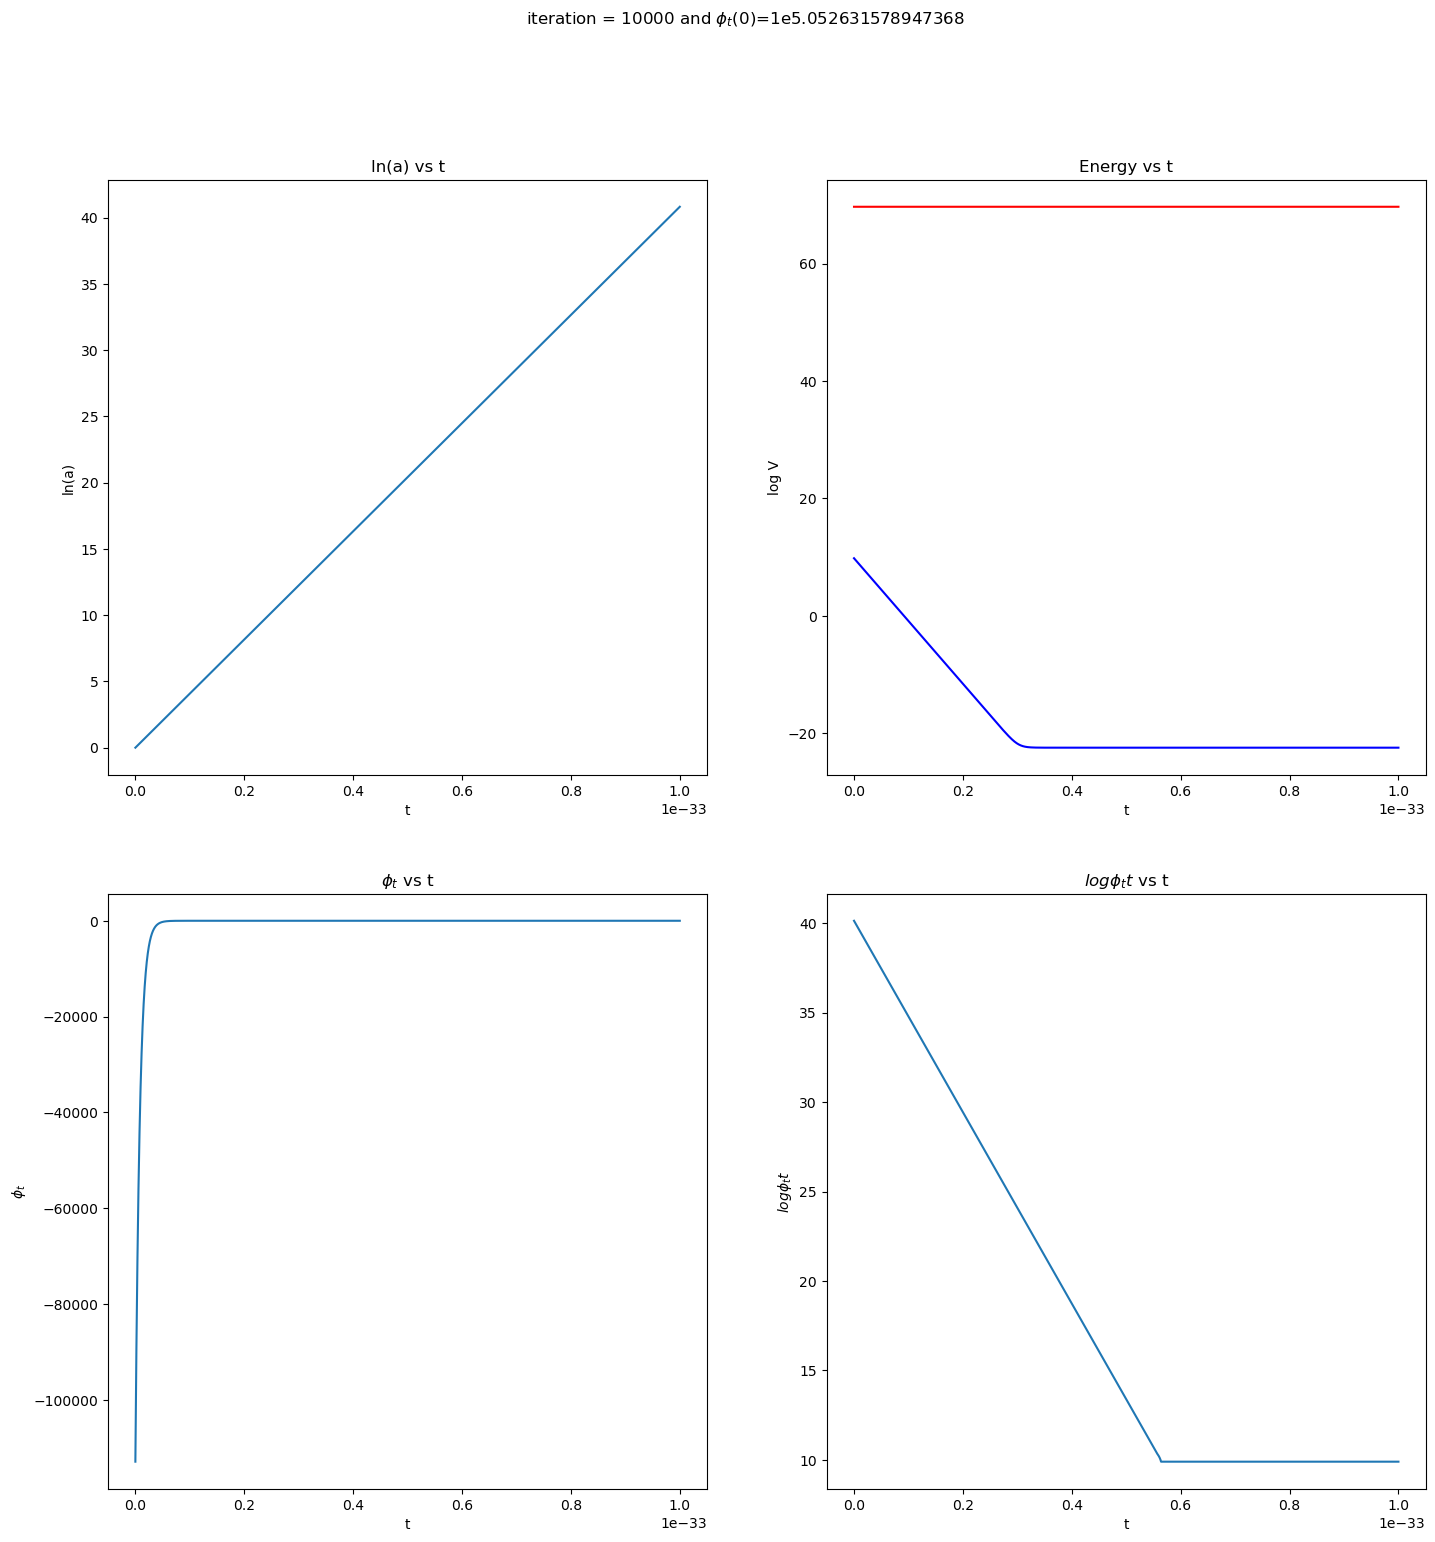

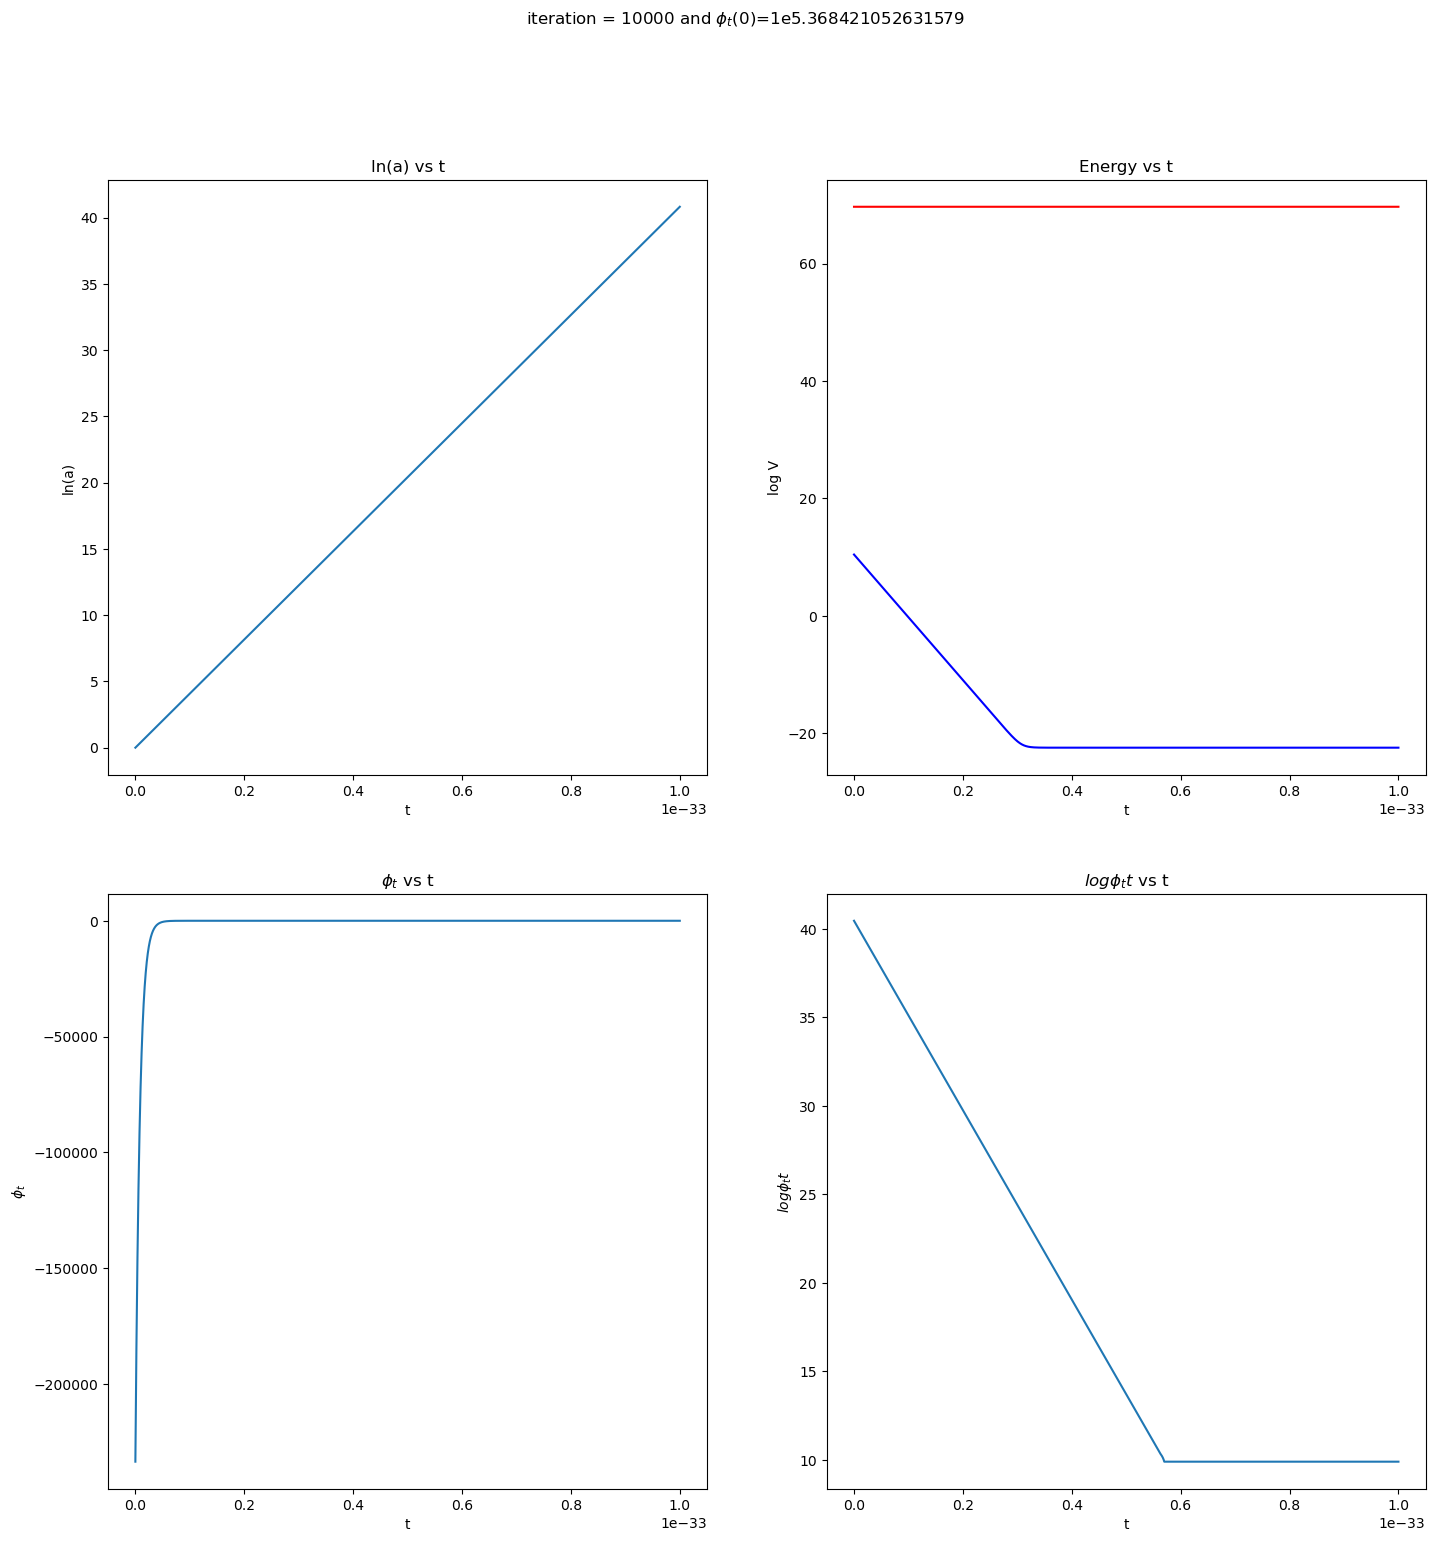

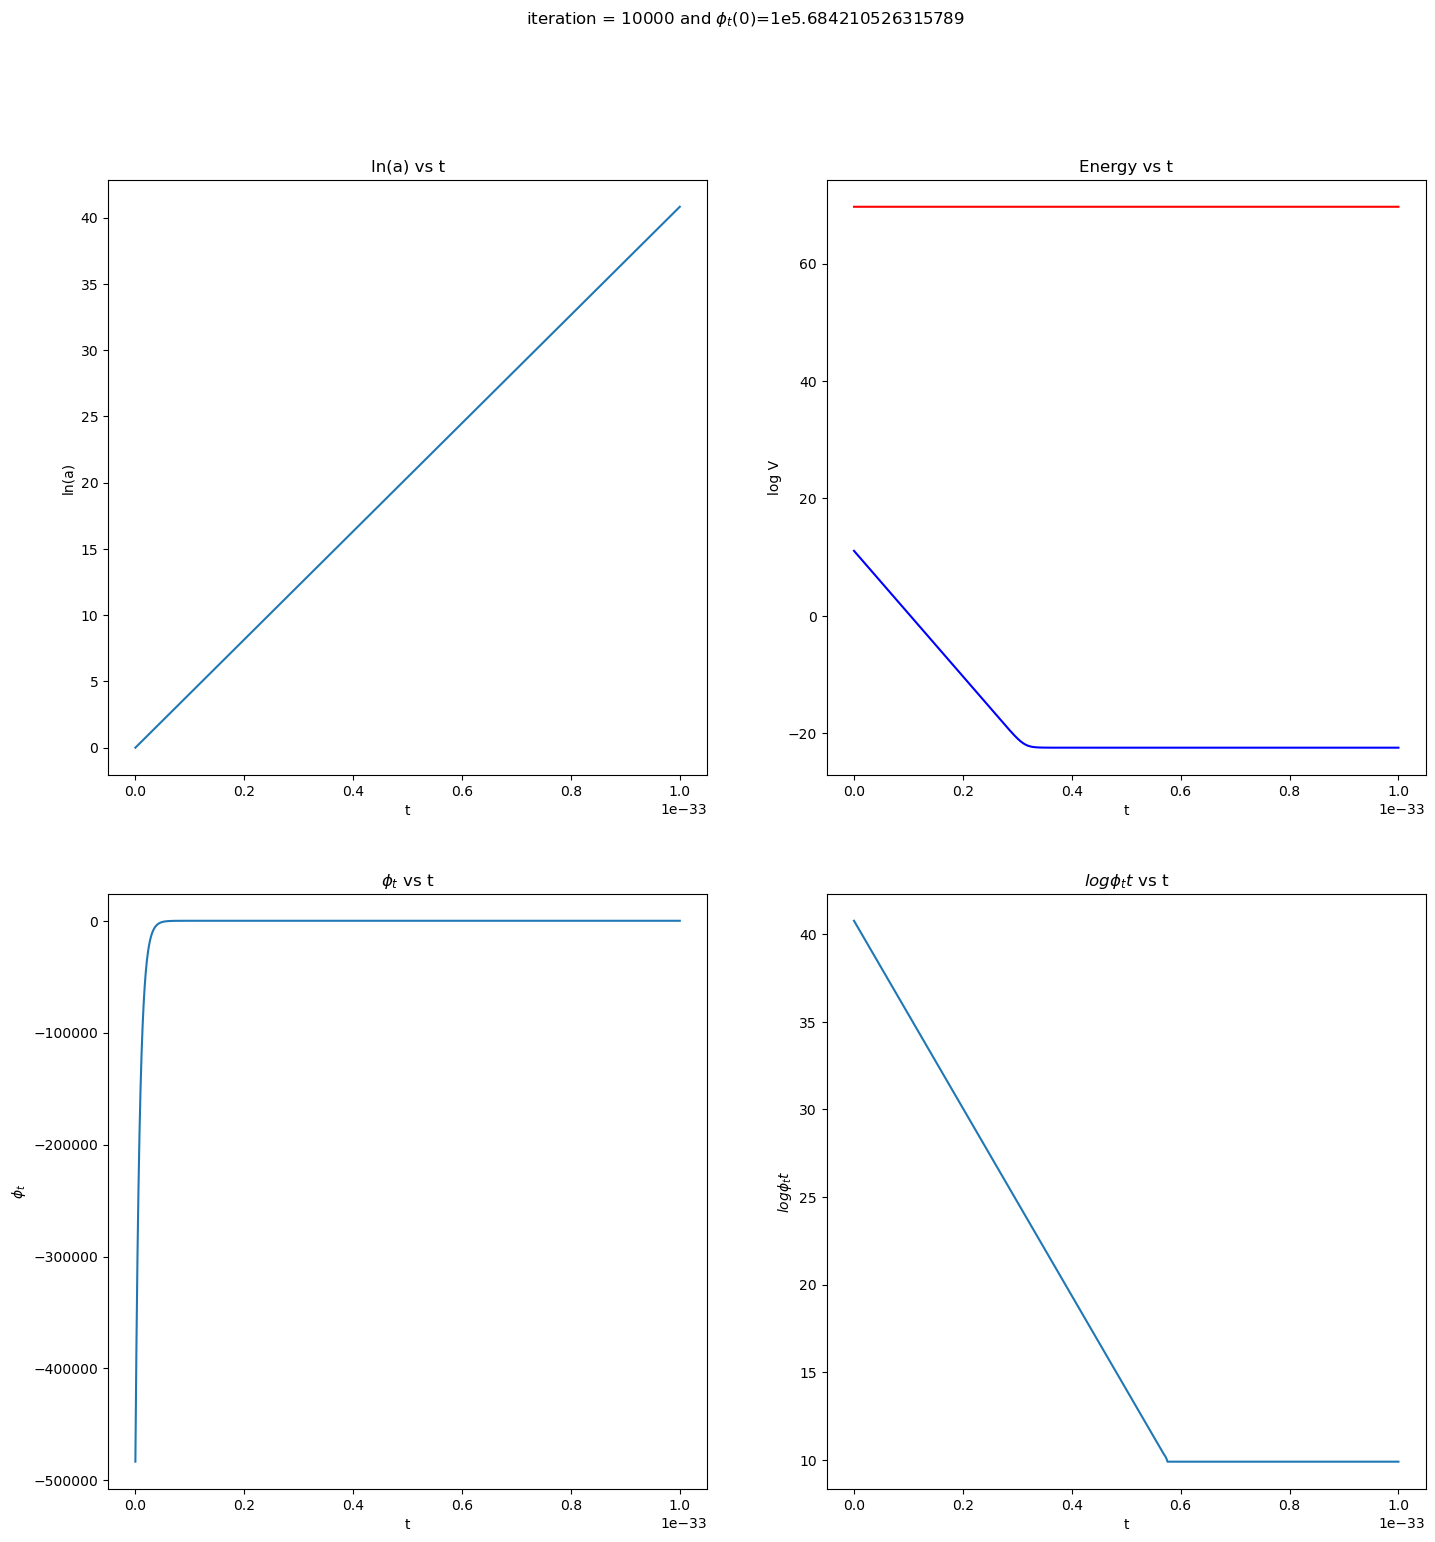

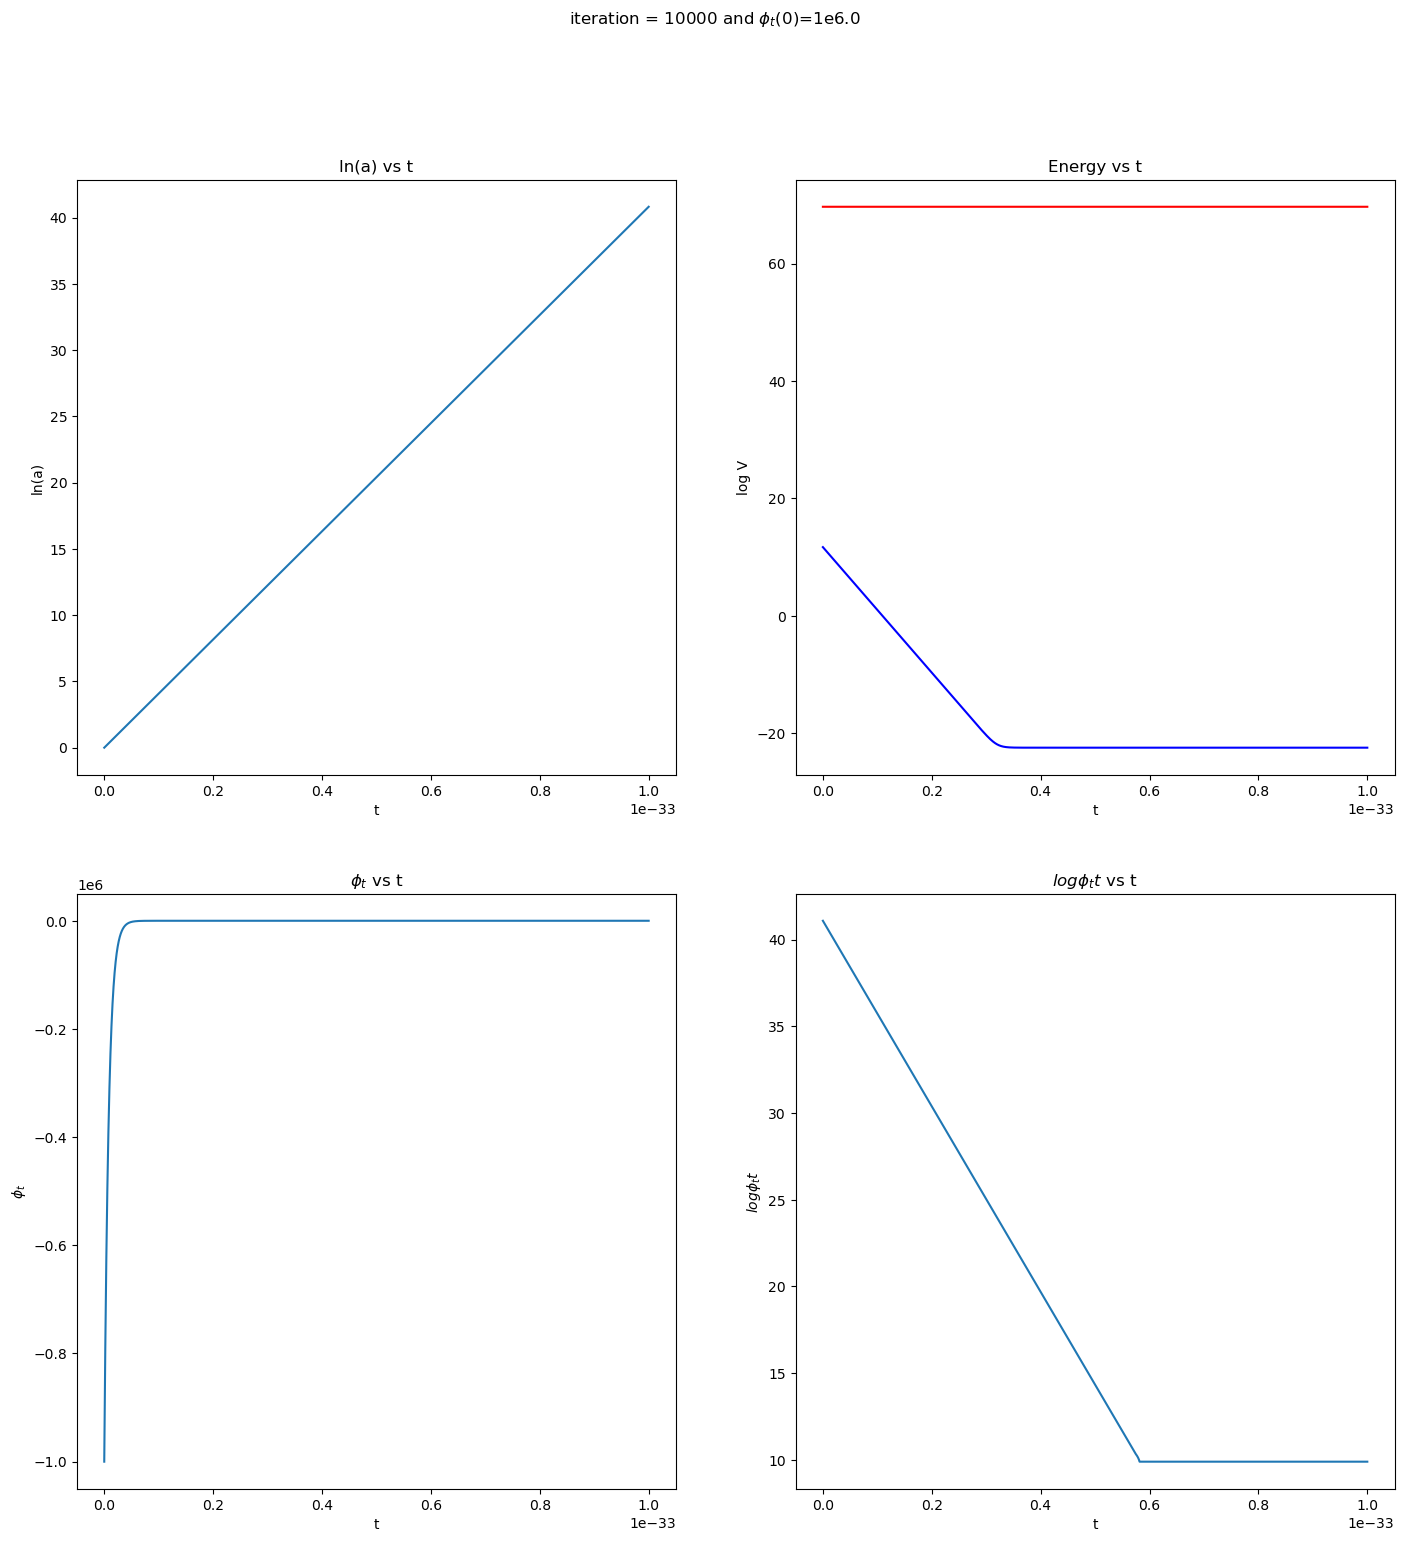

In [109]:
#select model
Model = 'simple'
#ODE
y_t_array =  np.logspace( 0 , 6 , 20 ) #solve differential equation for each y_t0
sign = -1 #sign of y_t0
step = 1e-37 #step size for each iteration in unit second
maximum = 1e-33 #maximum time for inflation in unit second
max_iteration = maximum/step #maximum iteration number

for j in range(len(y_t_array)):
    y_t0 = y_t_array[j]*sign
    i = 0
    y = [[],[],[]] #y, y_t, y_tt
    a_ln  = [[],[]] #ln(a)
    t = [0] #time epoch
    
    y[0].append(y0)
    y[1].append(y_t0)
    a_ln[0].append(0)
    while ( Potential(Model,y[0][i]) > 0.5* y[1][i]**2 and i < max_iteration): #stop when inflation criterion is not satisfied or reach maximum iteration
        y[2].append( -Nabla_Potential(Model,y[0][i]) -3 * H(Model,y[0][i], y[1][i]) * y[1][i])  #append y_tt
        y[1].append( y[1][i] + y[2][i]*step ) #append y_t
        y[0].append( y[0][i] + y[1][i]*step ) #append y
        t.append(t[i] + step) #append time

        a_ln[1].append( H(Model,y[0][i], y[1][i]) ) #append lna ^dot
        a_ln[0].append( a_ln[0][i] + a_ln[1][i]*step ) #append ln(a)
        i += 1
    y[2].append( -m**2 *y[0][i] -3 * H(Model,y[0][i], y[1][i]) * y[1][i]) #append y_tt for the last step to ensure the length of y_tt is the same as y_t and y

    
    #plot section
    y = np.array(y)
    a_ln = np.array(a_ln)
    
    fig , ax = plt.subplots(2,2,figsize=(17,17))
    fig.suptitle('iteration = {} and '.format(i)+'$\phi_t(0)$=1e{}'.format(np.log10(np.abs(y_t0))))
    ax[0,0].plot(t,a_ln[0])
    ax[0,0].set_title('ln(a) vs t')
    ax[0,0].set_ylabel('ln(a)')
    ax[0,0].set_xlabel('t')

    ax[0,1].plot(t,np.log10(Potential(Model,y[0])),color ='r',label = 'Potential')
    ax[0,1].plot(t,np.log10(0.5* y[1]**2) ,color = 'b',label ='Kinetic')
    ax[0,1].set_title('Energy vs t')
    ax[0,1].set_ylabel('log V')
    ax[0,1].set_xlabel('t')

    ax[1,0].plot(t,y[1])
    ax[1,0].set_title('$\phi_t$ vs t')
    ax[1,0].set_ylabel('$\phi_t$')
    ax[1,0].set_xlabel('t')

    #ax[2].plot(t,y[0]-y0*np.ones(len(t)))
    ax[1,1].plot(t,np.log10(np.abs(y[2])))
    ax[1,1].set_title('$log\phi_tt$ vs t')
    ax[1,1].set_ylabel('$log \phi_tt$')
    ax[1,1].set_xlabel('t')

    plt.savefig(os.path.join(out_path, 'y_t0_{}.png'.format(j)), dpi=100)